In [69]:
site = 'Dar_es_Salam'

scenario = "ssp245"
#scenario = "ssp585"

In [70]:
from google.colab import drive
drive.flush_and_unmount()

In [71]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [72]:
!pip install cftime

In [73]:
import xarray as xr
import pandas as pd
import numpy as np
from prophet import Prophet
#from neuralprophet import NeuralProphet
#from fbprophet import Prophet
import matplotlib.pyplot as plt
import pickle
import cftime
import os
import sys

In [74]:
#path = '/content/drive/MyDrive/Precipitation_Projection_AIMS/'

calib_start = pd.to_datetime('1985-01-01')
valid_end = pd.to_datetime('2014-12-31')

n_days = (valid_end - calib_start).days
n_calib = int(n_days*0.8)

calib_end = calib_start + pd.Timedelta(days=n_calib)

valid_start = calib_end + pd.Timedelta(days=1)
valid_end = valid_start + pd.Timedelta(days=n_days-n_calib)

projection_start = pd.to_datetime('2015-01-01')
projection_end = pd.to_datetime('2100-12-31')


print(f"Calibration period: {calib_start} to {calib_end}")
print(f"Validation period: {valid_start} to {valid_end}")

Calibration period: 1985-01-01 00:00:00 to 2008-12-30 00:00:00
Validation period: 2008-12-31 00:00:00 to 2015-01-01 00:00:00


In [75]:
path = '/content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/'
#path = '/content/drive/MyDrive/Precipitation_Projection_AIMS/'
if os.path.exists(path):
  sys.path.append(path)
else:
  path = os.getcwd()

print(f'path: {path}')
assert os.path.exists(path+ f'data/{site}')
directory_data = path + f'data/{site}/'

directory_training = directory_data + scenario + "/" + "training/"
directory_validation = directory_data + scenario + "/" + "validation/"
directory_projection = directory_data + scenario + "/" + "projection/"

if not os.path.exists(directory_training):
  os.makedirs(directory_training)
if not os.path.exists(directory_validation):
  os.makedirs(directory_validation)
if not os.path.exists(directory_projection):
  os.makedirs(directory_projection)

path: /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/


In [76]:
import dqm
import manage_files

In [77]:
data_obs = xr.open_dataset(directory_data + f'precip_cpc_{site}.nc')
data_hist = xr.open_dataset(directory_data + f'pr_historical_{site}_ensmean.nc')
data_model = xr.open_dataset(directory_data + f'pr_{scenario}_{site}_ensmean.nc')

Exception ignored in: <function CachingFileManager.__del__ at 0x7d2f50ae6020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/xarray/backends/file_manager.py", line 250, in __del__
  File "/usr/local/lib/python3.11/dist-packages/xarray/backends/file_manager.py", line 234, in close
  File "/usr/local/lib/python3.11/dist-packages/h5netcdf/core.py", line 1684, in close
  File "/usr/local/lib/python3.11/dist-packages/h5py/_hl/files.py", line 630, in close
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 355, in h5py.h5f.FileID._close_open_objects
RuntimeError: Can't decrement id ref count (unable to close file, errno = 107, error message = 'Transport endpoint is not connected')
Exception ignored in: <function CachingFileManager.__del__ at 0x7d2f50ae6020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-package

In [78]:
# Convert to DataFrame and reset index to have 'time' as a column
df_hist = data_hist.to_dataframe()
df_hist = df_hist.reset_index()

#==============================================================
df_obs = data_obs.to_dataframe()
df_obs = df_obs.reset_index() # Reset the index to default integer index

#===========================================================
df_model = data_model.to_dataframe()
df_model = df_model.reset_index()

#===========================================================


print(f"{'df_hist':<7},  {str(df_hist.shape)},  {list(df_hist.columns)}")
print(f"{'df_obs':<7},  {str(df_obs.shape)},  {list(df_obs.columns)}")
print(f"df_{scenario},  {str(df_model.shape)},  {list(df_model.columns)}")

df_hist,  (10800, 4),  ['time', 'lon', 'lat', 'pr']
df_obs ,  (10592, 4),  ['time', 'lon', 'lat', 'precip']
df_ssp245,  (30960, 4),  ['time', 'lon', 'lat', 'pr']


In [79]:
# prompt: écrire une fonction pour afficher le nombre de points de collecte presen dans chaque dataframe (cela en comptant le nombre de pairs longitude-latitude différente), afficher le pas de temps dans chaque df, ainisi que les dates de debut de collecte et de fin

def analyze_dataframes(dfs):
  """
  Analyze a list of dataframes to display information about collection points,
  time step, and start/end dates.

  Args:
    dfs: A dictionary where keys are dataframe names and values are the dataframes.
  """
  for name, df in dfs.items():
    print(f"--- Analysis for {name} ---")

    # Count unique latitude-longitude pairs (collection points)
    if 'lat' in df.columns and 'lon' in df.columns:
      unique_points = df[['lat', 'lon']].drop_duplicates().shape[0]
      print(f"Number of collection points: {unique_points}")
      print(df[['lat', 'lon']].drop_duplicates())

    else:
      print("Latitude and longitude columns not found.")

    # Determine time step
    if 'time' in df.columns and len(df['time']) > 1:
        # Ensure time column is datetime type
        if not pd.api.types.is_datetime64_any_dtype(df['time']):
            try:
                df['time'] = pd.to_datetime(df['time'])
            except Exception as e:
                print(f"Could not convert 'time' column to datetime: {e}")
                time_step = "Unknown (time conversion failed)"
                start_date = "Unknown (time conversion failed)"
                end_date = "Unknown (time conversion failed)"
                continue # Skip to the next dataframe
        else:
            time_diffs = df['time'].diff().dropna()
            if len(time_diffs) > 0:
                time_step = time_diffs.mode()[0]
                print(f"Estimated time step: {time_step}")
            else:
                time_step = "Cannot determine time step (less than 2 time entries)"
                print(time_step)

        # Display start and end dates
        start_date = df['time'].min()
        end_date = df['time'].max()
        print(f"Start date: {start_date}")
        print(f"End date: {end_date}")

    else:
      print("Time column not found or insufficient data.")

    print("-" * (len(f"--- Analysis for {name} --- \n")))


# Create a dictionary of your dataframes
dataframes = {
    'df_hist': df_hist,
    'df_obs': df_obs,
    f'df_{scenario}': df_model
}

# Call the function with your dictionary of dataframes
analyze_dataframes(dataframes)


--- Analysis for df_hist ---
Number of collection points: 1
   lat      lon
0 -6.8  39.2833
Estimated time step: 1 days 00:00:00
Start date: 1985-01-01 12:00:00
End date: 2014-07-27 12:00:00
------------------------------
--- Analysis for df_obs ---
Number of collection points: 1
   lat      lon
0 -6.8  39.2833
Estimated time step: 1 days 00:00:00
Start date: 1985-01-01 00:00:00
End date: 2014-12-31 00:00:00
-----------------------------
--- Analysis for df_ssp245 ---
Number of collection points: 1
   lat      lon
0 -6.8  39.2833
Estimated time step: 1 days 00:00:00
Start date: 2015-01-01 12:00:00
End date: 2099-10-06 12:00:00
--------------------------------


In [80]:
# Create a dictionary and standardize the precipitation column name to 'precip' for easier processing
df_s = {'obs': df_obs, 'hist' : df_hist, scenario : df_model}

for key, val in df_s.items():
    df_s[key] = val.copy()
    # Find the column containing 'precip' (case-insensitive) and rename to 'precip'
    col_precip_list = [col for col in df_s[key].columns if 'precip' in col.lower()]
    if not col_precip_list:
        # This should not happen if the previous renames worked, but as a safety check
        print(f"Warning: No column containing 'precip' found in dataframe '{key}'. Columns are: {df_s[key].columns}")
        # Attempt to find a 'pr' column if 'precip' wasn't found after rename (fallback)
        col_precip_list = [col for col in df_s[key].columns if 'pr' in col.lower()]
        if not col_precip_list:
             raise ValueError(f"Could not find 'precip' or 'pr' column in dataframe '{key}'. Cannot proceed.")

    col_precip = col_precip_list[0] # Take the first match
    if col_precip != 'precip': # Only rename if the name isn't already 'precip'
         df_s[key].rename(columns={col_precip: 'precip'}, inplace=True)

    # Ensure 'time' is datetime and normalize to remove time component
    # Use errors='coerce' to turn invalid parsing into NaT (Not a Time)
    #df_s[key]['time'] = pd.to_datetime(df_s[key]['time'], errors='coerce').dt.normalize()

    df_s[key]['time'] = df_s[key]['time'].dt.strftime('%Y-%m-%d')
    df_s[key]['time'] = pd.to_datetime(df_s[key]['time'])
    df_s[key]['time'] = df_s[key]['time'].dt.normalize()

    # Drop rows where time conversion failed - crucial!
    df_s[key].dropna(subset=['time', 'precip'], inplace=True)

    df_s[key] = df_s[key].sort_values(by='time').reset_index(drop=True)
    df_s[key] = df_s[key][['time', 'precip']]


# Assign to underscore variables for clarity in subsequent steps
_obs = df_s['obs'].copy()
_hist = df_s['hist'].copy()
_scenar = df_s[scenario].copy()

# --- Check number of unique collection points (copied from previous suggestion) ---
dataframes_to_check = {'_hist': _hist, '_obs': _obs, scenario: _scenar}

print("\n--- Checking Collection Points ---")
for name, df in dataframes_to_check.items():

    if 'lat' in df.columns and 'lon' in df.columns:
        unique_points = df[['lat', 'lon']].drop_duplicates().shape[0]
        print(f"Number of unique (lat, lon) points in {name}: {unique_points}")
        if unique_points > 1:
            print(f"  --> Warning: {name} contains multiple collection points.")
            print("      Consider spatially averaging the precipitation data before bias correction if you need a single regional time series.")

    else:
        print(f"\nLatitude and longitude columns not found in {name}. Assuming a single location or pre-averaged data.")
print("\n--- Collection Point Check Complete ---")


# --- Determine the common calibration period based on overlapping dates ---
# This defines the target date range for calibration
date_1 = max(_obs['time'].min(), _hist['time'].min())
date_2 = min(_obs['time'].max(), _hist['time'].max())


--- Checking Collection Points ---

Latitude and longitude columns not found in _hist. Assuming a single location or pre-averaged data.

Latitude and longitude columns not found in _obs. Assuming a single location or pre-averaged data.

Latitude and longitude columns not found in ssp245. Assuming a single location or pre-averaged data.

--- Collection Point Check Complete ---


In [81]:
print(f"\nTarget calibration period range based on max/min overlap: {date_1} to {date_2}")

# --- Filter dataframes to the target calibration period range ---
# Use .copy() to ensure these are independent DataFrames
_obs_calib_range = _obs[(_obs['time'] >= date_1) & (_obs['time'] <= date_2)].copy()
_hist_calib_range = _hist[(_hist['time'] >= date_1) & (_hist['time'] <= date_2)].copy()


_obs_aligned = _obs_calib_range
_hist_aligned = _hist_calib_range


Target calibration period range based on max/min overlap: 1985-01-02 00:00:00 to 2014-07-27 00:00:00


In [82]:
# --- Identify dates with NaNs in the observation data within the aligned data ---
# Ensure 'precip' column exists after potential resampling/filtering
if 'precip' not in _obs_aligned.columns:
     raise ValueError("'precip' column not found in _obs_aligned after alignment steps.")
if 'precip' not in _hist_aligned.columns:
     raise ValueError("'precip' column not found in _hist_aligned after alignment steps.")

assert _obs_aligned['time'].notna().all(), "Missing 'time' values in _obs_aligned"
assert _hist_aligned['time'].notna().all(), "Missing 'time' values in _hist_aligned"

n_obs_aligned_bf = len(_obs_aligned)
n_hist_aligned_bf = len(_hist_aligned)

# Drop rows with NaNs in the 'precip' column
_obs_aligned.dropna(inplace=True)
_hist_aligned.dropna(inplace=True)

print(f"\nNaN rows dropped from calibration _obs (after DropNa): ", 100-100*len(_obs_aligned)/n_obs_aligned_bf)
print(f"NaN rows dropped from calibration _hist (after DropNa): ", 100-100*len(_hist_aligned)/n_hist_aligned_bf)

common_times = _obs_aligned["time"].isin(_hist_aligned["time"])

# Filtrer les DataFrames
_obs_aligned = _obs_aligned[common_times].copy()
_hist_aligned = _hist_aligned[_hist_aligned["time"].isin(_obs_aligned["time"])].copy()

print(f"\nrows dropped from calibration _obs (after DropNa and alignement): ", 100.-100*len(_obs_aligned)/n_obs_aligned_bf)
print(f"rows dropped from calibration _hist (after DropNa and alignement): ", 100.-100*len(_hist_aligned)/n_hist_aligned_bf)

print(f'length _obs_aligned = {len(_obs_aligned)}')
print(f'length _obs_aligned = {len(_hist_aligned)}')


NaN rows dropped from calibration _obs (after DropNa):  0.0
NaN rows dropped from calibration _hist (after DropNa):  0.0

rows dropped from calibration _obs (after DropNa and alignement):  0.0
rows dropped from calibration _hist (after DropNa and alignement):  3.537364570793585
length _obs_aligned = 10417
length _obs_aligned = 10417


In [83]:
assert len(_obs_aligned) == len(_hist_aligned), "Lengths of _obs_aligned and _hist_aligned are not equal."
assert _obs_aligned.shape == _hist_aligned.shape, "Shapes of _obs_aligned and _hist_aligned are not equal."

In [84]:
#_obs_aligned = _obs_aligned.reset_index(drop=True)
#_hist_aligned = _hist_aligned.reset_index(drop=True)

_obs_for_corrector = _obs_aligned.copy()
_hist_for_corrector = _hist_aligned.copy()

# Create the corrector instance with the aligned and cleaned data
# Pass the cleaned dataframes. The calibration period dates should match the range of these dataframes.

In [85]:
if not(list(_obs_for_corrector.index) == list(range(len(_obs_for_corrector)))):
  _obs_for_corrector = _obs_for_corrector.reset_index(drop=True)

if not(list(_hist_for_corrector.index) == list(range(len(_hist_for_corrector)))):
  _hist_for_corrector = _hist_for_corrector.reset_index(drop=True)

In [86]:
start = date_1
end   = date_2

split = int(len(_obs_for_corrector)*0.8)
ind_train = range(split)
ind_test = range(split, len(_obs_for_corrector))

In [87]:
for i in range(len(_obs_for_corrector)):
    if _obs_for_corrector['time'].iloc[i] != _hist_for_corrector['time'].iloc[i]:
        print(f'index {i}: {_obs_for_corrector["time"].iloc[i]} != {_hist_for_corrector["time"].iloc[i]}')

In [88]:
print(dir(manage_files))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'os', 'pd', 'save_metrics']


/content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/Dar_es_Salam/ssp245/training/dqm_précipitations (mm|jour).png


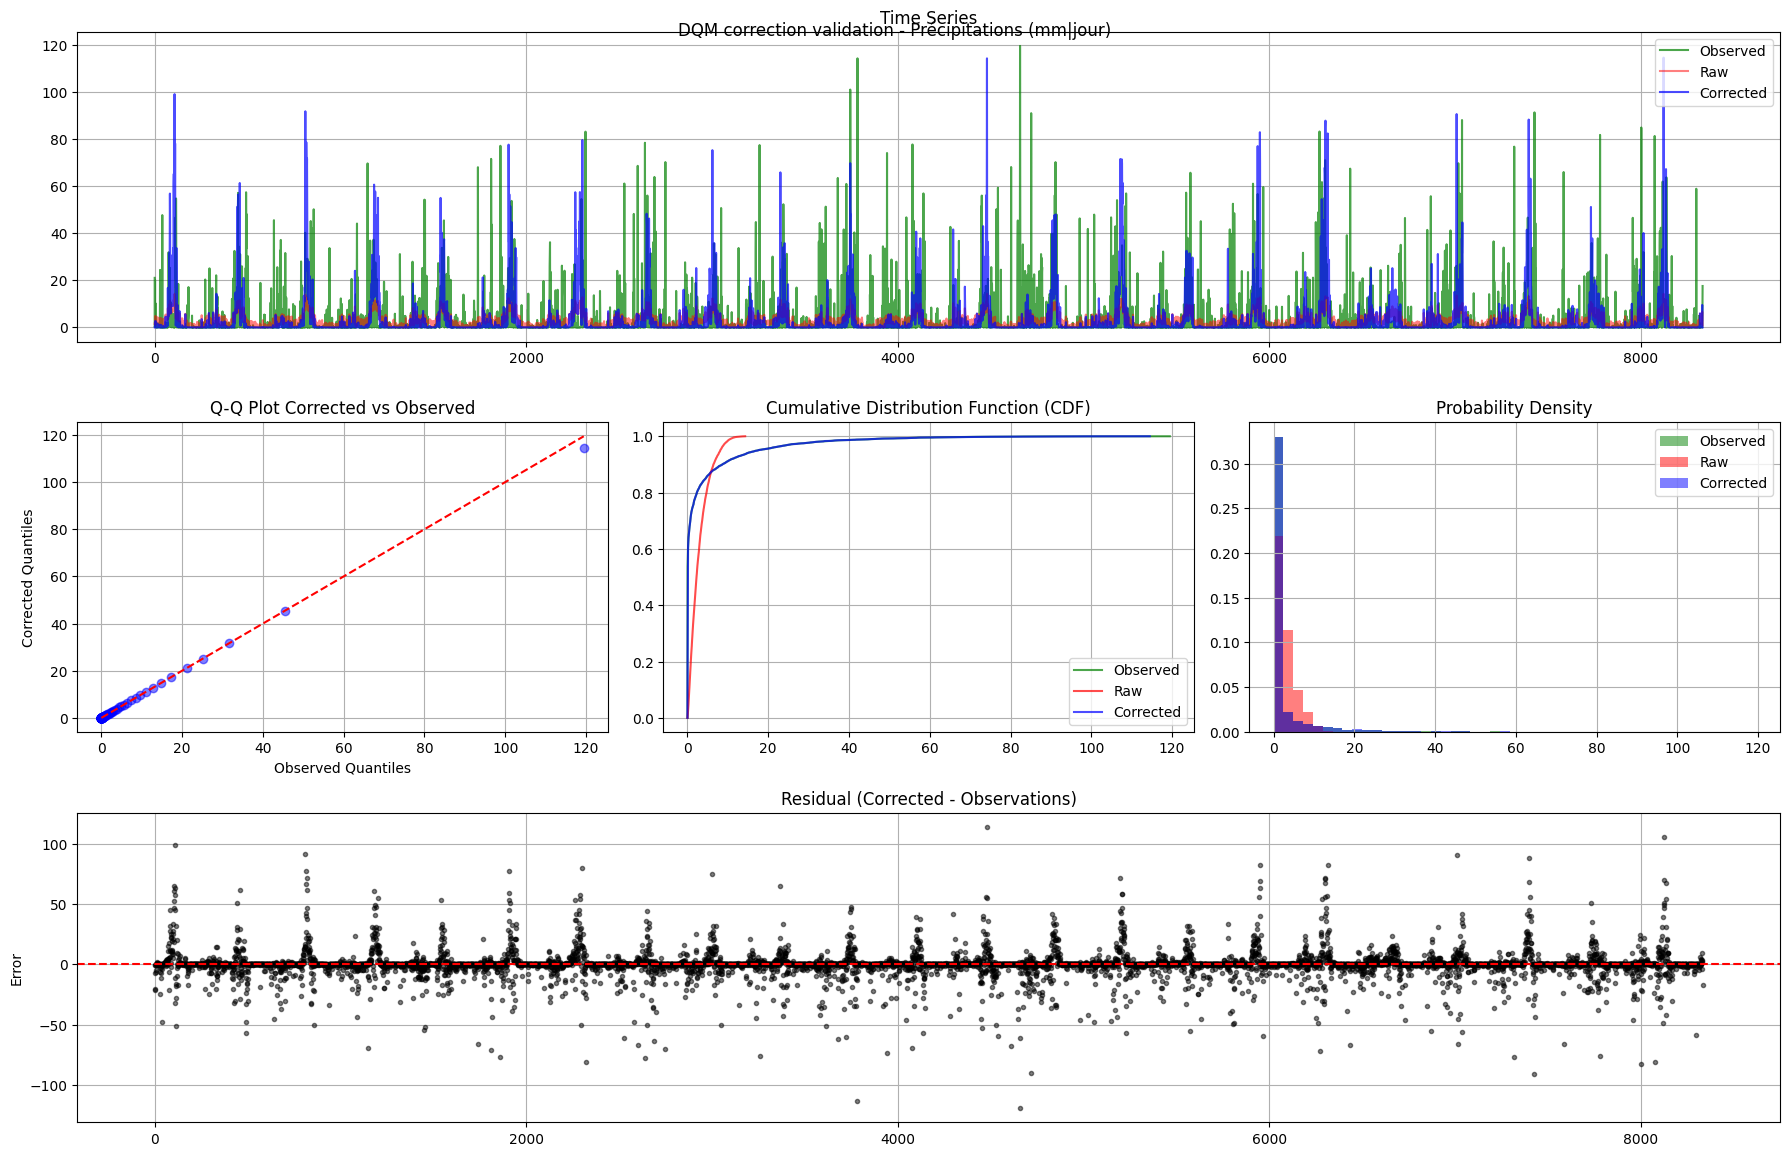

Metrics saved to /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/Dar_es_Salam/ssp245/training/dqm_traning_mtrics.csv
{'RMSE Brut': np.float32(8.521534), 'RMSE Corrige': np.float64(11.28330700508175), 'Biais Brut': np.float32(-0.0664501), 'Biais Corrige': np.float64(0.024394263410264818), 'Corrélation Brut': np.float64(0.20426369356693197), 'Corrélation Corrige': np.float64(0.15224116929012246), 'KS-test p-value': np.float64(0.0)}


In [89]:
# Entraînement sur la période historique
step = "training"
corrected_train, corrector = dqm.dqm(
    o=_obs_for_corrector.loc[ind_train, 'precip'].values,
    p=_hist_for_corrector.loc[ind_train, 'precip'].values,
    s=_hist_for_corrector.loc[ind_train, 'precip'].values,
    precip=True,
    pr_threshold=0.1
)

# Validation sur la période de test
metrics_train = dqm.validate_dqm_correction(
        obs=_obs_for_corrector.loc[ind_train , 'precip'].values,
        raw=_hist_for_corrector.loc[ind_train , 'precip'].values,
        corrected=corrected_train,
        directory=directory_training,
        #corrector=corrector,
        variable_name="Précipitations (mm|jour)"
    )

manage_files.save_metrics(metrics_train, 'dqm_traning_mtrics.csv', directory_training)
print(metrics_train)

/content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/Dar_es_Salam/ssp245/validation/dqm_précipitations (mm|jour).png


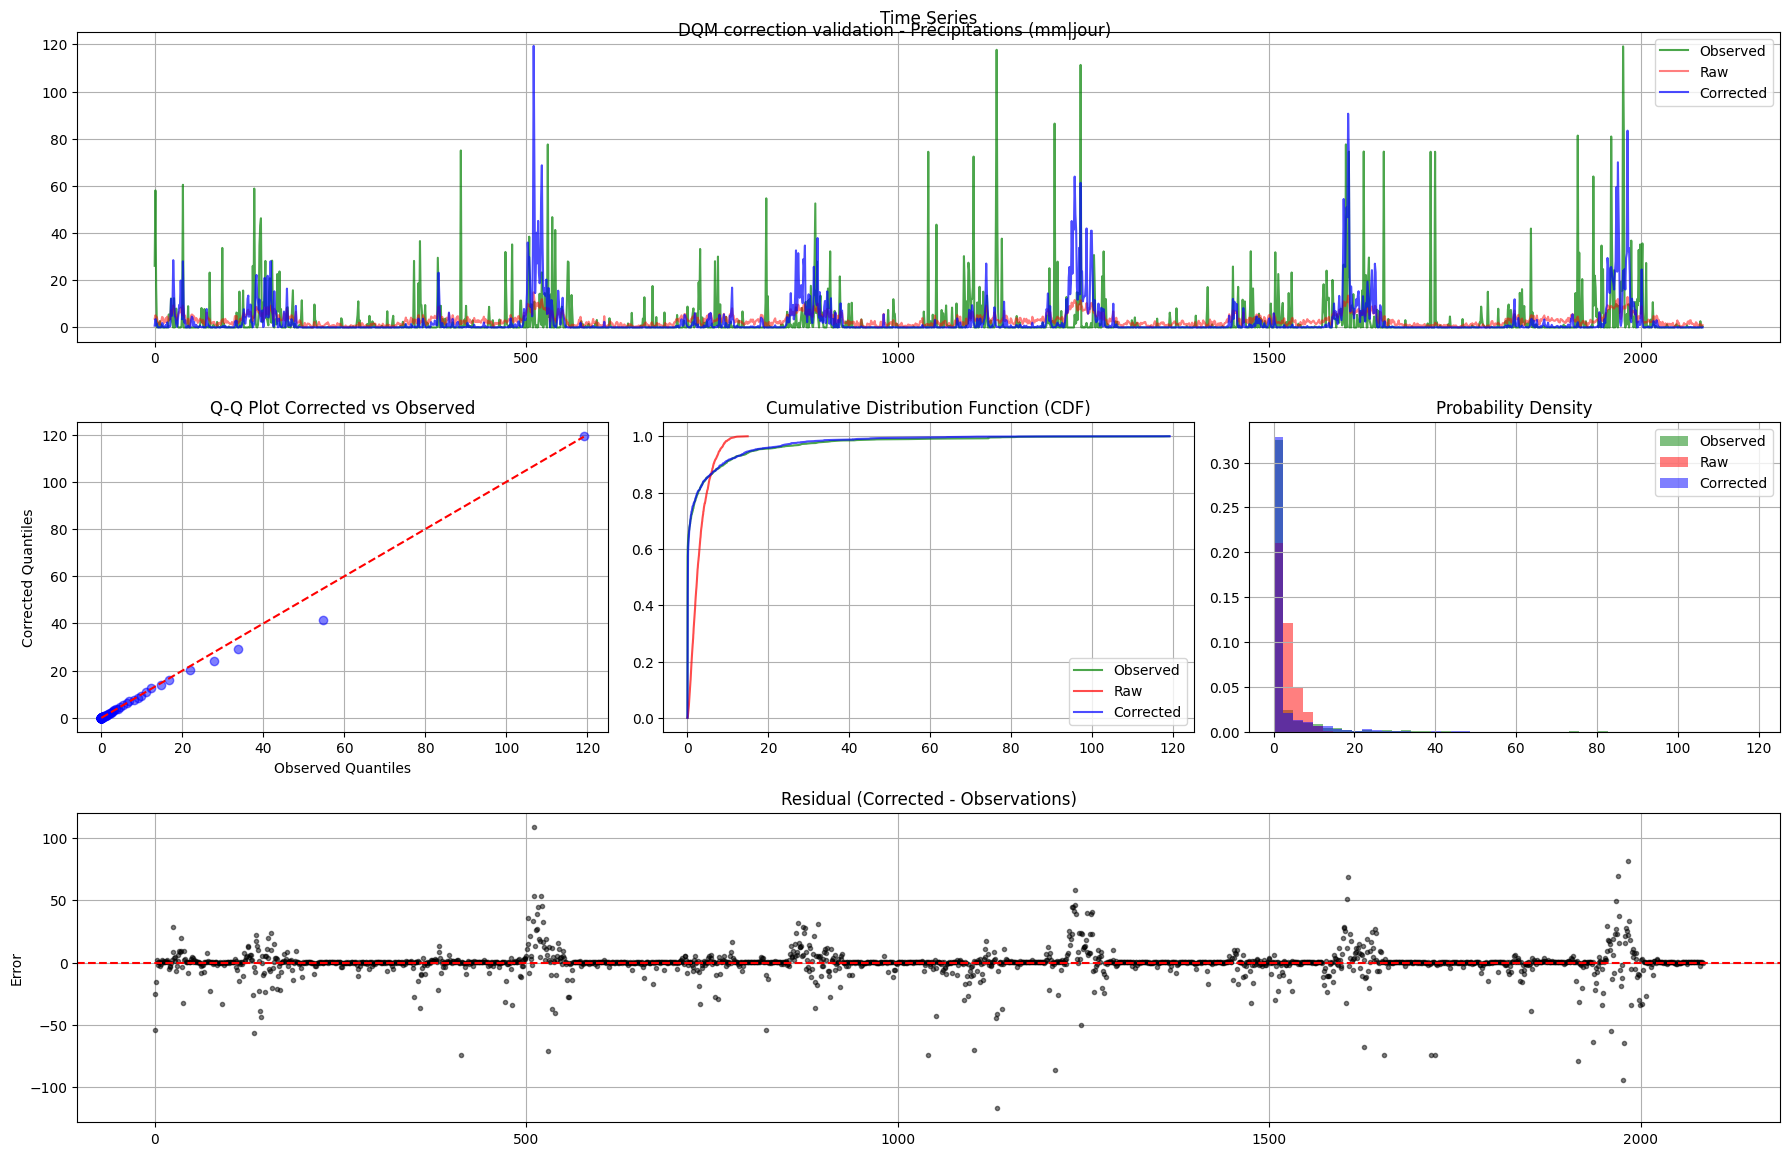

Metrics saved to /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/Dar_es_Salam/ssp245/validation/dqm_traning_metrics.csv
{'RMSE Brut': np.float32(9.859108), 'RMSE Corrige': np.float64(11.65821916767846), 'Biais Brut': np.float32(-0.24030618), 'Biais Corrige': np.float64(-0.33239101928128023), 'Corrélation Brut': np.float64(0.24090587275836062), 'Corrélation Corrige': np.float64(0.21903462844948005), 'KS-test p-value': np.float64(7.842869932183095e-290)}


In [90]:
# Application aux projections futures
corrected_test = dqm.apply_dqm(
    _hist_for_corrector.loc[ind_test , 'precip'].values,
    corrector
)

step = "validation"
# Validation sur la période de test
metrics_test = dqm.validate_dqm_correction(
        obs=_obs_for_corrector.loc[ind_test , 'precip'].values,
        raw=_hist_for_corrector.loc[ind_test , 'precip'].values,
        corrected=corrected_test,
        directory=directory_validation,
        #corrector=corrector,
        variable_name="Précipitations (mm|jour)"
    )
manage_files.save_metrics(metrics_test, 'dqm_traning_metrics.csv', directory_validation)
print(metrics_test)

In [91]:
extends_metrics_test = dqm.calculate_extended_metrics(
    _obs_for_corrector.loc[ind_test , 'precip'].values,
    _hist_for_corrector.loc[ind_test , 'precip'].values,
    corrected_test)

manage_files.save_metrics(extends_metrics_test, 'dqm_traning_extends_metrics', directory_validation)

print(extends_metrics_test)

Metrics saved to /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/Dar_es_Salam/ssp245/validation/dqm_traning_extends_metrics
{'RMSE Brut': np.float32(9.859108), 'RMSE Corrige': np.float64(11.65821916767846), 'Biais Brut': np.float32(-0.24030618), 'Biais Corrige': np.float64(-0.33239101928128023), 'R95p Brut': np.float32(-8.913514), 'R95p Corrige': np.float64(-0.8279809491640293), 'Dry Days Brut': np.int64(-1262), 'Dry Days Corrige': np.int64(-91), 'KS-test p-value': np.float64(7.842869932183095e-290)}


In [92]:
print(_scenar.columns)
_scenar.rename(columns={'pr': 'precip'}, inplace=True)

_scenar.dropna(subset=['time', 'precip'], inplace=True) # Supprime les lignes où 'precip' est NaN
_scenar.reset_index(drop=True, inplace=True) # Remet l'index à 0, 1, 2...
df_model = _scenar.copy()

Index(['time', 'precip'], dtype='object')


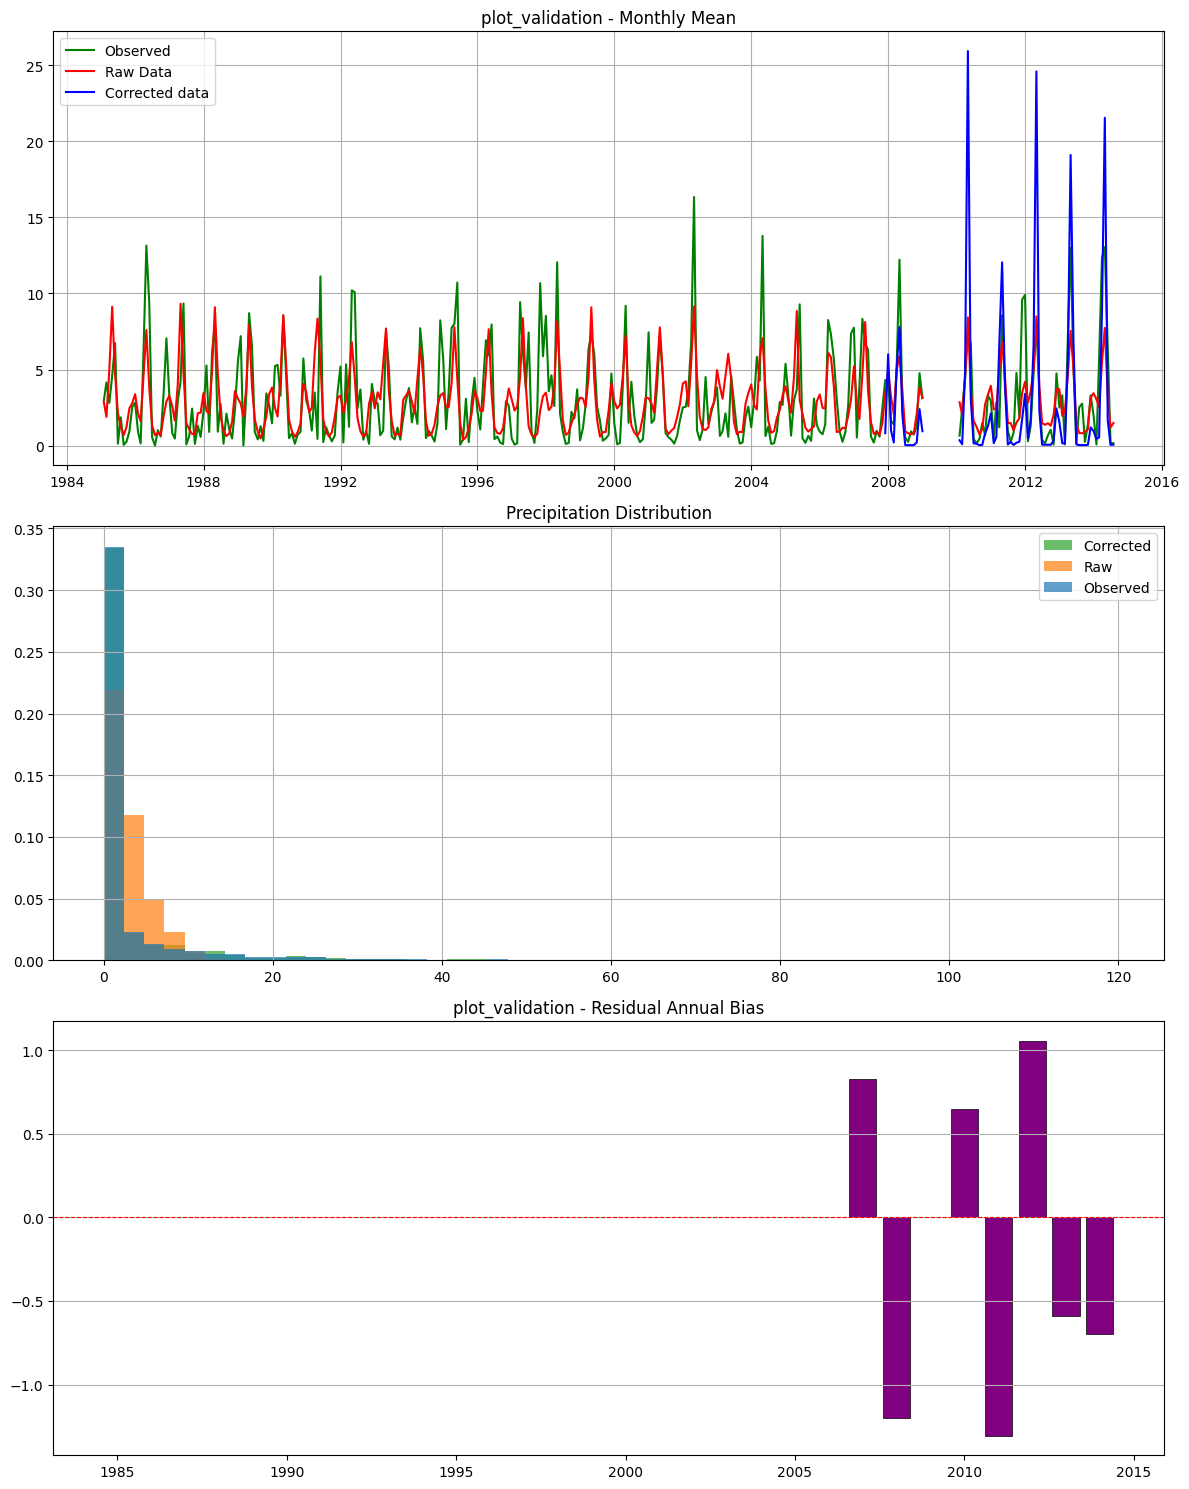

In [93]:
corrected_test_df = pd.DataFrame({'time': _obs_for_corrector.loc[ind_test, 'time'].values, 'precip': corrected_test})

FIG_ = dqm.plot_climate_validation(
    _obs_for_corrector,
    _hist_for_corrector,
    corrected_test_df,
    "plot_validation",
    directory_validation,
    aggr='D')

In [94]:
# ... (Your existing imports and code up to the point where _obs_for_corrector, _hist_for_corrector, and _scenar are defined)

from scipy.stats import linregress
import pandas as pd
import numpy as np
import os

# Function to compute statistics (mean, std, min, max, slope) for a DataFrame
def compute_precip_stats(df, name, directory, save=False):
    """
    Compute statistics for precipitation data in a DataFrame.

    Args:
        df: DataFrame with 'time' and 'precip' columns
        name: Name of the DataFrame (e.g., 'obs', 'hist', 'ssp585')
        directory: Directory to save the statistics (if save=True)
        save: Boolean to indicate whether to save stats to a CSV file

    Returns:
        Dictionary of statistics
    """
    try:
        # Ensure 'time' and 'precip' columns exist
        if 'time' not in df.columns or 'precip' not in df.columns:
            raise ValueError(f"'time' or 'precip' column missing in {name}")

        # Convert time to numeric for slope calculation (days since start)
        time_numeric = np.arange(len(df))

        # Calculate slope using linear regression
        slope, _, _, _, _ = linregress(time_numeric, df['precip'])

        # Compute statistics
        stats = {
            'mean': df['precip'].mean(),
            'std': df['precip'].std(),
            'min': df['precip'].min(),
            'max': df['precip'].max(),
            'slope': slope  # mm/day per day
        }

        # Print statistics
        print(f"\nStatistics for {name} ({site}):")
        print(f"  Mean: {stats['mean']:.2f} mm/day")
        print(f"  Std: {stats['std']:.2f} mm/day")
        print(f"  Min: {stats['min']:.2f} mm/day")
        print(f"  Max: {stats['max']:.2f} mm/day")
        print(f"  Slope: {stats['slope']:.6f} mm/day per day")

        # Optionally save to CSV
        if save:
            stats_df = pd.DataFrame([stats], index=[name])
            stats_file = os.path.join(directory, f'stats_{name}.csv')
            stats_df.to_csv(stats_file)
            print(f"Statistics saved to {stats_file}")

        return stats
    except Exception as e:
        print(f"Error computing stats for {name}: {e}")
        return None

# ... (Your existing code up to the point where _obs_for_corrector, _hist_for_corrector, and _scenar are defined)

# After defining _obs_for_corrector, _hist_for_corrector, and _scenar
# Compute and display statistics for each DataFrame
print("\n--- Computing Precipitation Statistics ---")
stats_obs = compute_precip_stats(_obs_for_corrector, 'obs', directory_validation, save=True)
stats_hist = compute_precip_stats(_hist_for_corrector, 'hist', directory_validation, save=True)
stats_scenar = compute_precip_stats(_scenar, scenario, directory_projection, save=True)

# ... (Rest of your existing code, including DQM correction, validation, and plotting)




--- Computing Precipitation Statistics ---

Statistics for obs (Dar_es_Salam):
  Mean: 3.04 mm/day
  Std: 8.99 mm/day
  Min: 0.00 mm/day
  Max: 119.44 mm/day
  Slope: 0.000030 mm/day per day
Statistics saved to /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/Dar_es_Salam/ssp245/validation/stats_obs.csv

Statistics for hist (Dar_es_Salam):
  Mean: 2.94 mm/day
  Std: 2.44 mm/day
  Min: 0.00 mm/day
  Max: 14.89 mm/day
  Slope: 0.000008 mm/day per day
Statistics saved to /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/Dar_es_Salam/ssp245/validation/stats_hist.csv

Statistics for ssp245 (Dar_es_Salam):
  Mean: 3.22 mm/day
  Std: 2.57 mm/day
  Min: 0.00 mm/day
  Max: 16.91 mm/day
  Slope: 0.000010 mm/day per day
Statistics saved to /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/Dar_e

/content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/Dar_es_Salam/ssp245/projection/dqm_précipitations (mm|jour).png


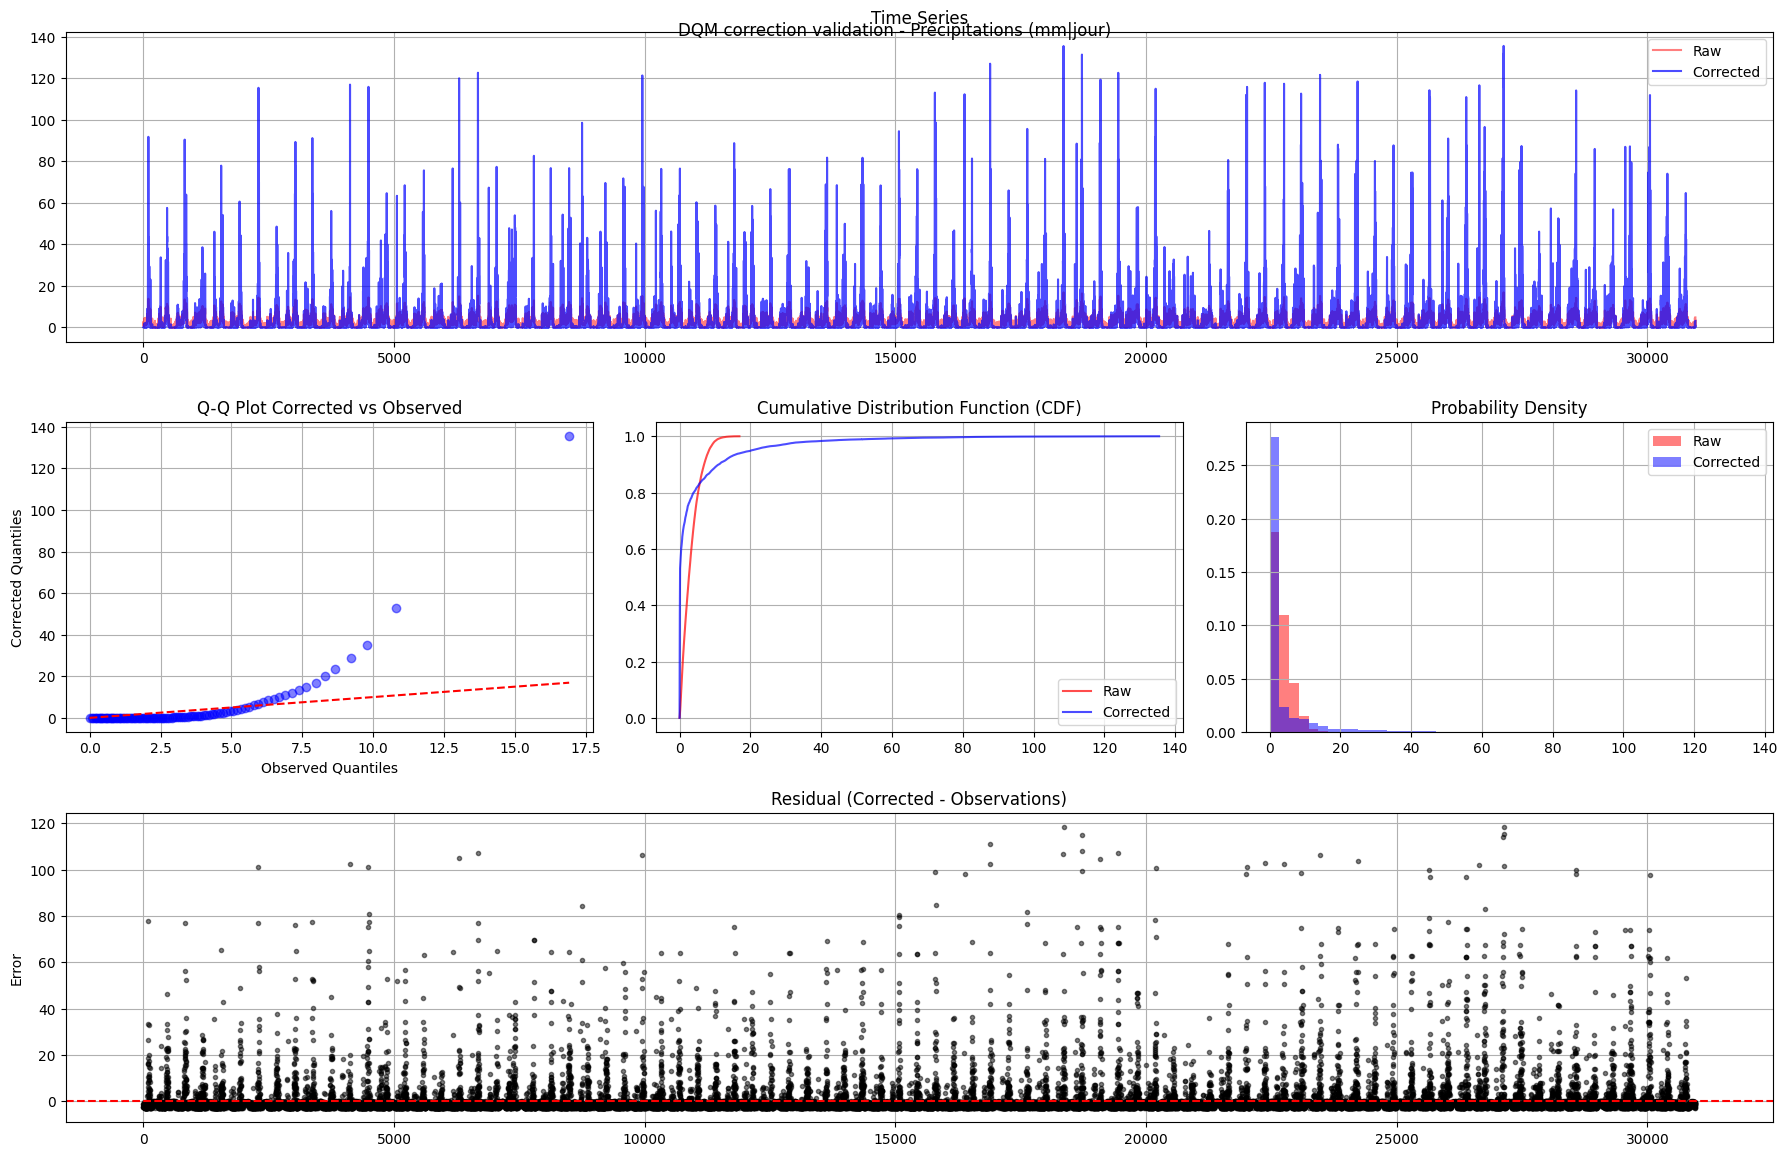

-1


In [95]:
# Application aux projections futures
projection = dqm.apply_dqm(
    df_model['precip'].values,
    corrector)
projection_df = pd.DataFrame({'time': df_model['time'].values, 'precip_projection': projection})
projection_df.to_csv(directory_projection + f"projection_{scenario}.csv")

step = "projection"
# Validation sur la période de test
metrics_test = dqm.validate_dqm_correction(
        obs=None,
        raw=df_model['precip'].values,
        corrected=projection,
        directory=directory_projection,
        #corrector=corrector,
        variable_name="Précipitations (mm|jour)"
    )
#manage_files.save_metrics(metrics_test, 'dqm_traning_metrics.csv', directory_projection)
print(metrics_test)

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools

# Define the scenarios
scenarios = ['ssp245', 'ssp585']
site = 'kigali'
path = '/content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/'

# Function to calculate precipitation indices
def calculate_indices(df, scenario, output_path):
    """
    Calculate precipitation indices for a given dataframe.

    Args:
        df: DataFrame with 'time' and 'precip' (or 'precip_projection') columns
        scenario: Scenario name (e.g., 'ssp245', 'ssp585')
        output_path: Directory to save the indices CSV

    Returns:
        DataFrame with calculated indices
    """
    try:
        # Ensure the precipitation column is named correctly
        precip_col = 'precip_projection' if 'precip_projection' in df.columns else 'precip'
        df = df.copy()
        df['year'] = df['time'].dt.year

        # Calculate the 95th percentile threshold for wet days (> 1 mm)
        wet_days = df[df[precip_col] > 1][precip_col]
        r95p_threshold = wet_days.quantile(0.95) if not wet_days.empty else np.nan

        indices = {'year': [], 'PRCPTOT': [], 'R95p': [], 'RX1day': [], 'RX5day': []}

        for year, group in df.groupby('year'):
            pr = group[precip_col].values
            indices['year'].append(year)
            # PRCPTOT: Total annual precipitation
            indices['PRCPTOT'].append(group[precip_col].sum())
            # R95p: Total precipitation from days exceeding the 95th percentile
            indices['R95p'].append(group[group[precip_col] > r95p_threshold][precip_col].sum() if not np.isnan(r95p_threshold) else 0)
            # RX1day: Maximum 1-day precipitation
            indices['RX1day'].append(pr.max())
            # RX5day: Maximum 5-day precipitation
            indices['RX5day'].append(max([pr[i:i+5].sum() for i in range(len(pr)-4)] + [0]))

        indices_df = pd.DataFrame(indices)
        indices_file = os.path.join(output_path, f'indices_{scenario}_{site}.csv')
        indices_df.to_csv(indices_file, index=False)
        print(f"Indices saved for {site} ({scenario}) in {indices_file}")
        return indices_df

    except Exception as e:
        print(f"Error calculating indices for {site} ({scenario}): {e}")
        return None

# Load projection data and calculate indices for both scenarios
indices_results = {}
for scenario in scenarios:
    # Define directories
    directory_data = path + f'data/{site}/'
    directory_projection = directory_data + scenario + "/" + "projection/"

    # Load the projection data
    projection_file = os.path.join(directory_projection, f'projection_{scenario}.csv')
    if not os.path.exists(projection_file):
        print(f"Projection file not found for {site} ({scenario}): {projection_file}")
        indices_results[scenario] = None
        continue

    projection_df = pd.read_csv(projection_file)
    projection_df['time'] = pd.to_datetime(projection_df['time'])

    # Calculate indices
    indices_results[scenario] = calculate_indices(projection_df, scenario, directory_projection)

# Plotting the indices
if indices_results['ssp245'] is not None and indices_results['ssp585'] is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Extreme Precipitation Indices for {site}")

    indices = ['PRCPTOT', 'R95p', 'RX1day', 'RX5day']
    units = {
        'PRCPTOT': 'mm/year',
        'R95p': 'mm/year',
        'RX1day': 'mm/day',
        'RX5day': 'mm/5-day'
    }

    for ax, index in zip(axes.flatten(), indices):
        # Plot ssp245
        indices_results['ssp245'].plot(x='year', y=index, ax=ax, label='SSP2-4.5', color='blue')
        # Plot ssp585
        indices_results['ssp585'].plot(x='year', y=index, ax=ax, label='SSP5-8.5', color='red')
        ax.set_title(f"{index} ({units[index]})")
        ax.set_xlabel('Year')
        ax.set_ylabel(units[index])
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate suptitle
    plot_file = os.path.join(directory_data, f'indices_plot_{site}.png')
    plt.savefig(plot_file)
    plt.close()
    print(f"Plot saved for {site} in {plot_file}")
else:
    print(f"Skipping visualization for {site} due to missing indices for one or both scenarios")

Indices saved for kigali (ssp245) in /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/kigali/ssp245/projection/indices_ssp245_kigali.csv
Indices saved for kigali (ssp585) in /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/kigali/ssp585/projection/indices_ssp585_kigali.csv
Plot saved for kigali in /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/kigali/indices_plot_kigali.png


In [ ]:
# Plotting the indices with trend lines
if indices_results['ssp245'] is not None and indices_results['ssp585'] is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Extreme Precipitation Indices for {site}")

    indices = ['PRCPTOT', 'R95p', 'RX1day', 'RX5day']
    units = {
        'PRCPTOT': 'mm/year',
        'R95p': 'mm/year',
        'RX1day': 'mm/day',
        'RX5day': 'mm/5-day'
    }

    for ax, index in zip(axes.flatten(), indices):
        # Plot ssp245
        ssp245_data = indices_results['ssp245'][['year', index]].dropna()
        if not ssp245_data.empty:
            ssp245_data.plot(x='year', y=index, ax=ax, label='SSP2-4.5', color='blue')
            # SSP2-4.5 trend
            if len(ssp245_data) > 1:
                years_245 = ssp245_data['year'].values
                values_245 = ssp245_data[index].values
                z1 = np.polyfit(years_245, values_245, 1)
                p1 = np.poly1d(z1)
                ax.plot(years_245, p1(years_245), color='blue', linestyle='--', label='SSP2-4.5 Trend')
            else:
                print(f"Warning: Insufficient data for SSP2-4.5 trend line for {index} (only {len(ssp245_data)} points)")
        else:
            print(f"Warning: No valid data for SSP2-4.5 {index} after dropping NaNs")

        # Plot ssp585
        ssp585_data = indices_results['ssp585'][['year', index]].dropna()
        if not ssp585_data.empty:
            ssp585_data.plot(x='year', y=index, ax=ax, label='SSP5-8.5', color='red')
            # SSP5-8.5 trend
            if len(ssp585_data) > 1:
                years_585 = ssp585_data['year'].values
                values_585 = ssp585_data[index].values
                z2 = np.polyfit(years_585, values_585, 1)
                p2 = np.poly1d(z2)
                ax.plot(years_585, p2(years_585), color='red', linestyle='--', label='SSP5-8.5 Trend')
            else:
                print(f"Warning: Insufficient data for SSP5-8.5 trend line for {index} (only {len(ssp585_data)} points)")
        else:
            print(f"Warning: No valid data for SSP5-8.5 {index} after dropping NaNs")

        ax.set_title(f"{index} ({units[index]})")
        ax.set_xlabel('Year')
        ax.set_ylabel(units[index])
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate suptitle
    plot_file = os.path.join(directory_data, f'indices_plot_{site}_with_trend.png')
    plt.savefig(plot_file)
    plt.close()
    print(f"Plot with trend lines saved for {site} in {plot_file}")
else:
    print(f"Skipping visualization for {site} due to missing indices for one or both scenarios")
    if indices_results['ssp245'] is None:
        print("No indices calculated for ssp245")
    if indices_results['ssp585'] is None:
        print("No indices calculated for ssp585")
    # Debug: Inspect the indices DataFrames
    for scenario in scenarios:
        if indices_results[scenario] is not None:
            print(f"\nDebug info for {scenario}:")
            print(f"Shape: {indices_results[scenario].shape}")
            print(f"Columns: {indices_results[scenario].columns.tolist()}")
            print(f"Years: {indices_results[scenario]['year'].dropna().unique()}")
            for index in ['PRCPTOT', 'R95p', 'RX1day', 'RX5day']:
                print(f"Non-NaN count for {index}: {indices_results[scenario][index].dropna().count()}")

Plot with trend lines saved for kampala in /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/kampala/indices_plot_kampala_with_trend.png


In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.7/733.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 16.2 MB/s eta 0:00:00


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools

# Define the scenarios
scenarios = ['ssp245', 'ssp585']
site = 'nairobi'
path = '/content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/'

# Function to calculate precipitation indices
def calculate_indices(df, scenario, output_path):
    """
    Calculate precipitation indices for a given dataframe.

    Args:
        df: DataFrame with 'time' and 'precip' (or 'precip_projection') columns
        scenario: Scenario name (e.g., 'ssp245', 'ssp585')
        output_path: Directory to save the indices CSV

    Returns:
        DataFrame with calculated indices
    """
    try:
        # Ensure the precipitation column is named correctly
        precip_col = 'precip_projection' if 'precip_projection' in df.columns else 'precip'
        if precip_col not in df.columns:
            print(f"Error: Precipitation column ('precip' or 'precip_projection') not found in DataFrame for {scenario}")
            return None

        df = df.copy()
        # Ensure time is datetime
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
        if df['time'].isna().any():
            print(f"Warning: {df['time'].isna().sum()} invalid 'time' values in {scenario}")
            df = df.dropna(subset=['time'])

        df['year'] = df['time'].dt.year

        # Check for valid numeric precipitation data
        df[precip_col] = pd.to_numeric(df[precip_col], errors='coerce')
        if df[precip_col].isna().any():
            print(f"Warning: {df[precip_col].isna().sum()} non-numeric or missing values in '{precip_col}' for {scenario}")
            df = df.dropna(subset=[precip_col])

        # Calculate the 95th percentile threshold for wet days (> 1 mm)
        wet_days = df[df[precip_col] > 1][precip_col]
        r95p_threshold = wet_days.quantile(0.95) if not wet_days.empty else np.nan

        indices = {'year': [], 'PRCPTOT': [], 'R95p': [], 'RX1day': [], 'RX5day': [], 'SDII': []}

        for year, group in df.groupby('year'):
            pr = group[precip_col].values
            indices['year'].append(year)
            # PRCPTOT: Total annual precipitation
            indices['PRCPTOT'].append(group[precip_col].sum())
            # R95p: Total precipitation from days exceeding the 95th percentile
            indices['R95p'].append(group[group[precip_col] > r95p_threshold][precip_col].sum() if not np.isnan(r95p_threshold) else 0)
            # RX1day: Maximum 1-day precipitation
            indices['RX1day'].append(pr.max() if len(pr) > 0 else np.nan)
            # RX5day: Maximum 5-day precipitation
            indices['RX5day'].append(max([pr[i:i+5].sum() for i in range(len(pr)-4)] + [0]) if len(pr) >= 5 else np.nan)
            # SDII: Simple Daily Intensity Index (mean precipitation on wet days > 1 mm)
            wet_days_year = group[group[precip_col] > 1][precip_col]
            indices['SDII'].append(wet_days_year.mean() if not wet_days_year.empty else np.nan)

        indices_df = pd.DataFrame(indices)
        indices_file = os.path.join(output_path, f'indices_{scenario}_{site}.csv')
        indices_df.to_csv(indices_file, index=False)
        print(f"Indices saved for {site} ({scenario}) in {indices_file}")
        return indices_df

    except Exception as e:
        print(f"Error calculating indices for {site} ({scenario}): {e}")
        return None

# Load projection data and calculate indices for both scenarios
indices_results = {}
for scenario in scenarios:
    # Define directories
    directory_data = path + f'data/{site}/'
    directory_projection = directory_data + scenario + "/" + "projection/"

    # Verify directory exists
    if not os.path.exists(directory_projection):
        print(f"Directory not found for {site} ({scenario}): {directory_projection}")
        indices_results[scenario] = None
        continue

    # Load the projection data
    projection_file = os.path.join(directory_projection, f'projection_{scenario}.csv')
    print(f"Checking for projection file: {projection_file}")
    if not os.path.exists(projection_file):
        print(f"Projection file not found for {site} ({scenario}): {projection_file}")
        indices_results[scenario] = None
        continue

    try:
        projection_df = pd.read_csv(projection_file)
        print(f"Loaded {projection_file} with columns: {projection_df.columns.tolist()}")
        projection_df['time'] = pd.to_datetime(projection_df['time'], errors='coerce')
        if projection_df['time'].isna().any():
            print(f"Warning: {projection_df['time'].isna().sum()} invalid 'time' values in {projection_file}")
            projection_df = projection_df.dropna(subset=['time'])
        indices_results[scenario] = calculate_indices(projection_df, scenario, directory_projection)
    except Exception as e:
        print(f"Error loading or processing {projection_file}: {e}")
        indices_results[scenario] = None

# Plotting the indices with trend lines
if indices_results['ssp245'] is not None and indices_results['ssp585'] is not None:
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3x2 grid for 5 indices
    fig.suptitle(f"Extreme Precipitation Indices for {site}")

    indices = ['PRCPTOT', 'R95p', 'RX1day', 'RX5day', 'SDII']
    units = {
        'PRCPTOT': 'mm/year',
        'R95p': 'mm/year',
        'RX1day': 'mm/day',
        'RX5day': 'mm/5-day',
        'SDII': 'mm/day'
    }

    # Flatten axes, but handle the extra subplot
    axes_flat = axes.flatten()
    for i, index in enumerate(indices):
        ax = axes_flat[i]
        # Plot ssp245
        ssp245_data = indices_results['ssp245'][['year', index]].dropna()
        if not ssp245_data.empty:
            ssp245_data.plot(x='year', y=index, ax=ax, label='SSP2-4.5', color='blue')
            # SSP2-4.5 trend
            if len(ssp245_data) > 1:
                years_245 = ssp245_data['year'].values
                values_245 = ssp245_data[index].values
                z1 = np.polyfit(years_245, values_245, 1)
                p1 = np.poly1d(z1)
                ax.plot(years_245, p1(years_245), color='blue', linestyle='--', label='SSP2-4.5 Trend')
            else:
                print(f"Warning: Insufficient data for SSP2-4.5 trend line for {index} (only {len(ssp245_data)} points)")
        else:
            print(f"Warning: No valid data for SSP2-4.5 {index} after dropping NaNs")

        # Plot ssp585
        ssp585_data = indices_results['ssp585'][['year', index]].dropna()
        if not ssp585_data.empty:
            ssp585_data.plot(x='year', y=index, ax=ax, label='SSP5-8.5', color='red')
            # SSP5-8.5 trend
            if len(ssp585_data) > 1:
                years_585 = ssp585_data['year'].values
                values_585 = ssp585_data[index].values
                z2 = np.polyfit(years_585, values_585, 1)
                p2 = np.poly1d(z2)
                ax.plot(years_585, p2(years_585), color='red', linestyle='--', label='SSP5-8.5 Trend')
            else:
                print(f"Warning: Insufficient data for SSP5-8.5 trend line for {index} (only {len(ssp585_data)} points)")
        else:
            print(f"Warning: No valid data for SSP5-8.5 {index} after dropping NaNs")

        ax.set_title(f"{index} ({units[index]})")
        ax.set_xlabel('Year')
        ax.set_ylabel(units[index])
        ax.legend()

    # Hide the unused subplot (bottom right in 3x2 grid)
    axes_flat[-1].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate suptitle
    plot_file = os.path.join(directory_data, f'indices_plot_{site}_with_trend_sdii.png')
    plt.savefig(plot_file)
    plt.close()
    print(f"Plot with trend lines saved for {site} in {plot_file}")
else:
    print(f"Skipping visualization for {site} due to missing indices for one or both scenarios")
    if indices_results['ssp245'] is None:
        print("No indices calculated for ssp245")
    if indices_results['ssp585'] is None:
        print("No indices calculated for ssp585")
    # Debug: Inspect the indices DataFrames
    for scenario in scenarios:
        if indices_results[scenario] is not None:
            print(f"\nDebug info for {scenario}:")
            print(f"Shape: {indices_results[scenario].shape}")
            print(f"Columns: {indices_results[scenario].columns.tolist()}")
            print(f"Years: {indices_results[scenario]['year'].dropna().unique()}")
            for index in ['PRCPTOT', 'R95p', 'RX1day', 'RX5day', 'SDII']:
                print(f"Non-NaN count for {index}: {indices_results[scenario][index].dropna().count()}")

Checking for projection file: /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/nairobi/ssp245/projection/projection_ssp245.csv
Loaded /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/nairobi/ssp245/projection/projection_ssp245.csv with columns: ['Unnamed: 0', 'time', 'precip_projection']
Indices saved for nairobi (ssp245) in /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/nairobi/ssp245/projection/indices_ssp245_nairobi.csv
Checking for projection file: /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/nairobi/ssp585/projection/projection_ssp585.csv
Loaded /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/nairobi/ssp585/projection/projection_ssp585

Période d'entraînement (Calib DQM & Train LSTM): 1985-01-01 00:00:00 à 2008-12-30 00:00:00
Période de validation (Valid DQM & Test LSTM): 2008-12-31 00:00:00 à 2015-01-01 00:00:00
Période de projection: 2015-01-01 00:00:00 à 2100-12-31 00:00:00

Taille de la fenêtre temporelle (window_size): 31

Nombre de jours dans df_model original: 30960
Nombre de jours dans df_scenar_cleaned (après dropna): 30960

Correction DQM appliquée sur les données du modèle historique et scénario.
df_hist_corrected shape: (10417, 3)
df_scenar_corrected shape: (30960, 3)

Nombre de jours/séquences pour l'entraînement LSTM: 8716
Shape des séquences d'entraînement X: (8716, 31, 8)
Shape de la cible d'entraînement y: (8716,)

Nombre de jours/séquences pour le test LSTM: 1639
Shape des séquences de test X: (1639, 31, 8)
Shape de la cible de test y: (1639,)

Shapes après mise à l'échelle (avec séquences):
X_train_scaled: (8716, 31, 8)
y_train_scaled: (8716, 1)
X_test_scaled: (1639, 31, 8)
y_test_scaled: (1639, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Entraînement du modèle LSTM...


Epoch 1/100
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 10.8333 - mae: 1.6858

218/218 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - loss: 10.8130 - mae: 1.6847 - val_loss: 7.8211 - val_mae: 1.1025
Epoch 2/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.5105 - mae: 1.6338

218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 9.5030 - mae: 1.6333 - val_loss: 7.0984 - val_mae: 1.0537
Epoch 3/100
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 9.3291 - mae: 1.6088

218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 9.3140 - mae: 1.6078 - val_loss: 6.9889 - val_mae: 1.0744
Epoch 4/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.1718 - mae: 1.6051

218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 9.1645 - mae: 1.6045 - val_loss: 6.9050 - val_mae: 1.0614
Epoch 5/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.9751 - mae: 1.5956

218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 8.9680 - mae: 1.5951 - val_loss: 6.5458 - val_mae: 1.1739
Epoch 6/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 8.9222 - mae: 1.5907 - val_loss: 6.6048 - val_mae: 1.1171
Epoch 7/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 8.8133 - mae: 1.5932 - val_loss: 6.8490 - val_mae: 1.0939
Epoch 8/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 8.7494 - mae: 1.5894 - val_loss: 6.6908 - val_mae: 1.1456
Epoch 9/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 8.7426 - mae: 1.6038 - val_loss: 6.6984 - val_mae: 1.1813
Epoch 10/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 8.6484 - mae: 1.5941 - val_loss: 6.8383 - val_mae: 1.1094
Epoch 11/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 8.6021 - mae: 1.5929 - val_loss: 6.7539 - val_mae: 1.1057
Epoch 12/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 8.5436 - mae: 1.5989 - val_loss: 7.0137 - val_mae: 1.0448
Epoch 13/100
218/218 ━━━━━━━━━━━━━━━━━━━━

218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 7.2335 - mae: 1.4988 - val_loss: 6.4970 - val_mae: 1.3959
Epoch 47/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 7.5155 - mae: 1.5131 - val_loss: 6.8998 - val_mae: 1.3663
Epoch 48/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - loss: 7.4111 - mae: 1.5247 - val_loss: 6.7832 - val_mae: 1.2400
Epoch 49/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 7.3784 - mae: 1.4981 - val_loss: 7.0363 - val_mae: 1.4080
Epoch 50/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 7.4076 - mae: 1.5092 - val_loss: 6.7709 - val_mae: 1.2970
Epoch 51/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 7.1276 - mae: 1.4721 - val_loss: 6.7982 - val_mae: 1.3720
Epoch 52/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 6.9669 - mae: 1.4452 - val_loss: 6.8820 - val_mae: 1.5099
Epoch 53/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 7.0849 - mae: 1.4834 - val_loss: 6.7357 - val_mae: 1.3221
Epoch 54/100
218/218 ━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 31, 72)         │        17,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 72)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 72)         │           288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 48)             │        17,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,565 (416.27 KB)

 Trainable params: 35,473 (138.57 KB)

 Non-trainable params: 144 (576.00 B)

 Optimizer params: 70,948 (277.14 KB)


Évaluation du modèle sur la période de validation...
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
RMSE (LSTM Train): 6.5101
R² (LSTM Train): -0.8402
RMSE (LSTM Test): 5.3610
R² (LSTM Test): -0.2470

Métriques LSTM sauvegardées à: /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/validation/addis_ababa_ssp585_lstm_metrics_validation_ws31.csv
Figure de validation LSTM sauvegardée à: /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/validation/addis_ababa_ssp585_lstm_validation_plot_ws31.png

Début de la période pour la construction des séquences de projection: 2014-12-02 00:00:00

Réalisation de la projection future...
967/967 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step
!!! DEBUG PROJECTION !!! Longueur projection_plot_dates: 30930, Longueur y_projection_pred_clipped: 30929
Longueur full_


Tous les résultats de projection sauvegardés dans: /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp585/projection/
Figure de projection sauvegardée à: /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp585/projection/addis_ababa_ssp585_projection_plot_ws31.png

--- Processus terminé avec succès ---


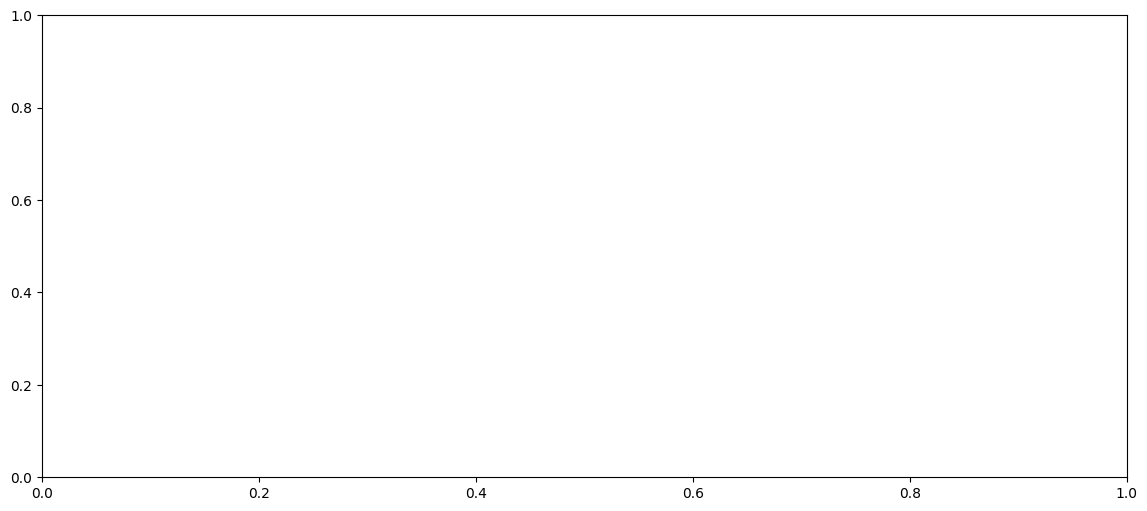

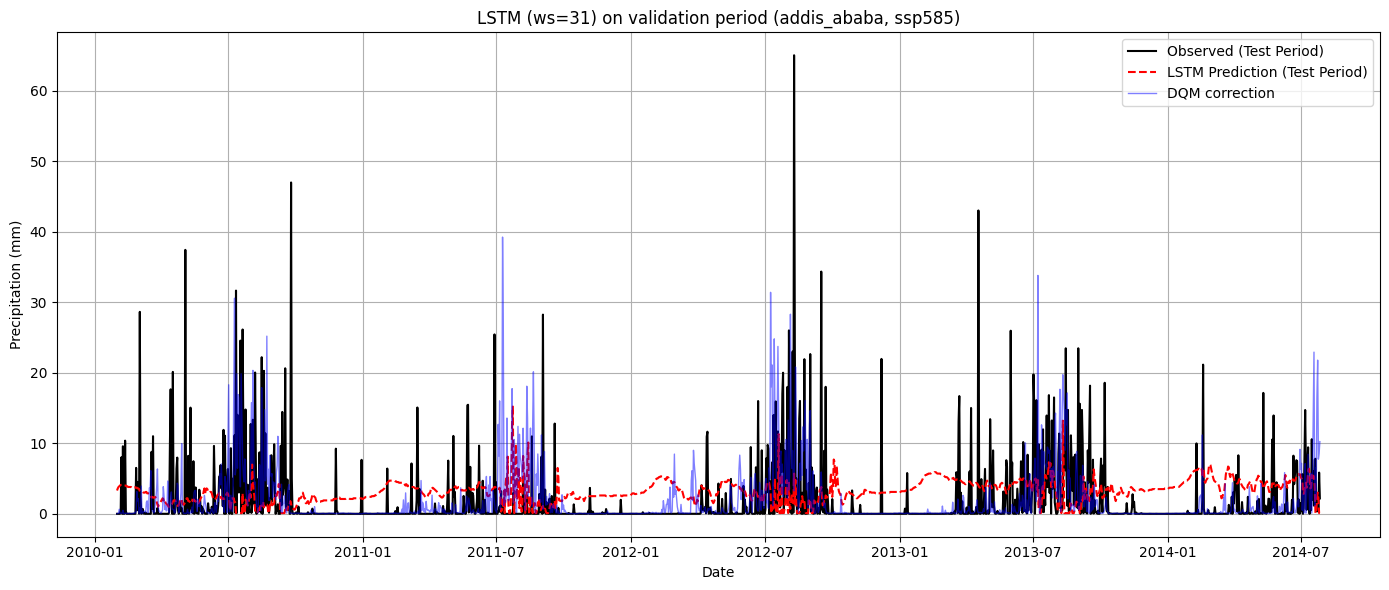

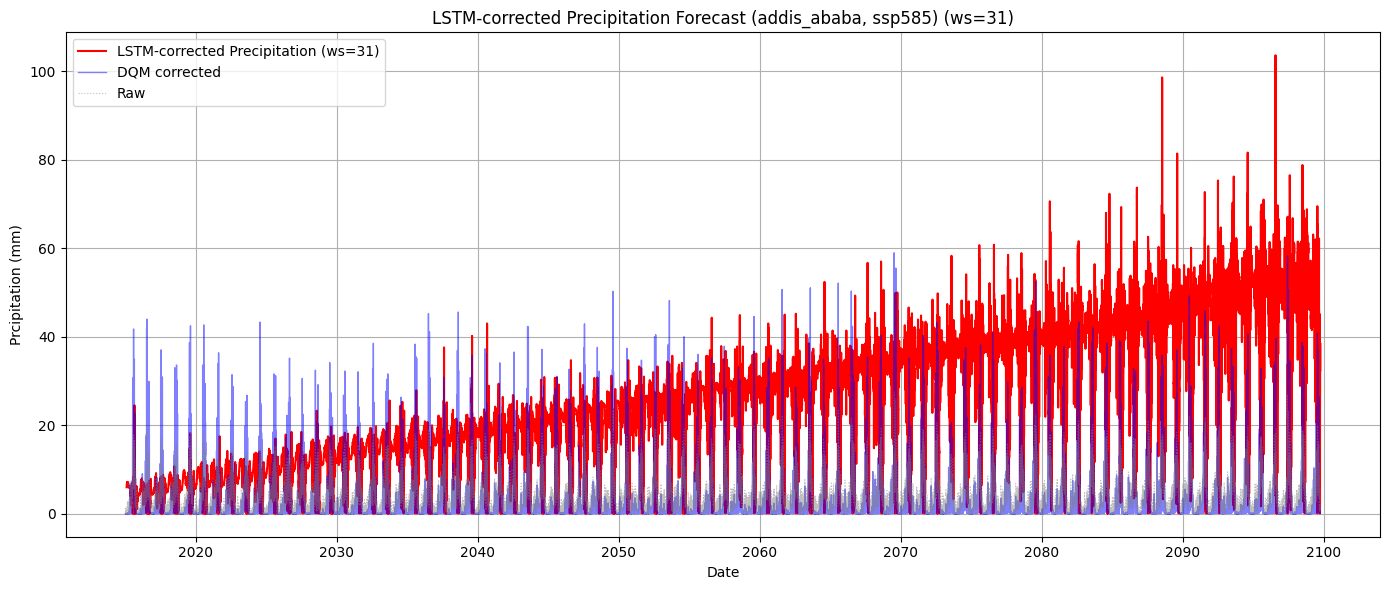

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pickle
import os
import math
import mlflow  # Optionnel pour le tracking
import sys

# --- Supposons que ces variables et dataframes sont déjà définis et disponibles ---
# calib_start, calib_end, valid_start, valid_end, projection_start, projection_end
# _obs_for_corrector (Observations, e.g., 1985-2014, colonne 'precip')
# _hist_for_corrector (Modèle Historique, e.g., 1985-2014, colonne 'precip')
# df_model (Modèle Scénario, e.g., 1985-2100, colonne 'precip')
# corrector (l'objet DQM corrector entraîné précédemment)
# directory_training, directory_validation, directory_projection
# site, scenario

print(f"Période d'entraînement (Calib DQM & Train LSTM): {calib_start} à {calib_end}")
print(f"Période de validation (Valid DQM & Test LSTM): {valid_start} à {valid_end}")
print(f"Période de projection: {projection_start} à {projection_end}")

# --- Hyperparamètres pour la séquence temporelle ---
window_size = 31 # Taille de la fenêtre (nombre de jours passés)
print(f"\nTaille de la fenêtre temporelle (window_size): {window_size}")

# --- Préparation des données ---
df_scenar_cleaned = df_model.copy()
assert df_scenar_cleaned['time'].isnull().sum() == 0, "Null values found in df_scenar_cleaned['time']."
df_scenar_cleaned.dropna(subset=['precip'], inplace=True)
df_scenar_cleaned = df_scenar_cleaned.sort_values('time').reset_index(drop=True)
print(f"\nNombre de jours dans df_model original: {len(df_model)}")
print(f"Nombre de jours dans df_scenar_cleaned (après dropna): {len(df_scenar_cleaned)}")

# Appliquer la correction DQM
hist_corrected_values = dqm.apply_dqm(_hist_for_corrector['precip'].values, corrector)
# hist_corrected_values = _hist_for_corrector['precip'].values   # attention
df_hist_corrected = _hist_for_corrector.copy()
df_hist_corrected['precip_corrected'] = hist_corrected_values

scenar_corrected_values = dqm.apply_dqm(df_scenar_cleaned['precip'].values, corrector)
df_scenar_corrected = df_scenar_cleaned.copy()
df_scenar_corrected['precip_corrected'] = scenar_corrected_values

print("\nCorrection DQM appliquée sur les données du modèle historique et scénario.")
print(f"df_hist_corrected shape: {df_hist_corrected.shape}")
print(f"df_scenar_corrected shape: {df_scenar_corrected.shape}")

# --- Ajout des Caractéristiques ---
def add_features(df, precip_col='precip'):
    df['day_of_year'] = df['time'].dt.dayofyear
    df['month'] = df['time'].dt.month
    df['sin_doy'] = np.sin(2 * math.pi * df['day_of_year'] / 365.25)
    df['cos_doy'] = np.cos(2 * math.pi * df['day_of_year'] / 365.25)
    df['sin_month'] = np.sin(2 * math.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * math.pi * df['month'] / 12)
    df['year'] = df['time'].dt.year

    if 'precip_corrected' in df.columns:
        df['rolling_mean_7'] = df['precip_corrected'].rolling(window=7).mean().fillna(0)
        df['rolling_std_7'] = df['precip_corrected'].rolling(window=7).std().fillna(0)
    return df

df_hist_corrected = add_features(df_hist_corrected, precip_col='precip_corrected')
_obs_for_corrector_features = add_features(_obs_for_corrector.copy(), precip_col='precip')
df_scenar_corrected = add_features(df_scenar_corrected, precip_col='precip_corrected')

# --- Préparer les Données en Séquences ---
# Fonction corrigée pour créer les séquences
"""
def create_sequences(data, window_size, feature_cols):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Sélectionner la fenêtre de 'window_size' jours
        window_data = data.iloc[i:(i + window_size)]

        # Extraire les valeurs des colonnes de features pour cette fenêtre
        # Cela donnera un tableau numpy de forme (window_size, nombre_de_features)
        seq_x = window_data[feature_cols].values

        print("windows_data columns = ", window_data.columns)

        # La cible y est la précipitation OBSERVÉE du DERNIER jour de la fenêtre
        seq_y = window_data.iloc[-1]['precip_obs'] # -1 pour le dernier jour de la fenêtre

        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
"""

def create_sequences(data, window_size, feature_cols, include_target=True):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Sélectionner la fenêtre de 'window_size' jours
        window_data = data.iloc[i:(i + window_size)]

        # Extraire les valeurs des colonnes de features pour cette fenêtre
        seq_x = window_data[feature_cols].values

        if include_target:
             # La cible y est la précipitation OBSERVÉE du DERNIER jour de la fenêtre
             # Assurez-vous que 'precip_obs' existe dans le dataframe si include_target est True
             if 'precip_obs' not in window_data.columns:
                  raise ValueError("La colonne 'precip_obs' est requise lorsque include_target est True.")
             seq_y = window_data.iloc[-1]['precip_obs']
             y.append(seq_y)

        X.append(seq_x)

    if include_target:
        return np.array(X), np.array(y)
    else:
        return np.array(X) # Retourner seulement X pour la projection


feature_cols = ['precip_corrected', 'sin_doy', 'cos_doy', 'sin_month', 'cos_month', 'year', 'rolling_mean_7', 'rolling_std_7']

# Préparation données d'entraînement
lstm_train_input_features = df_hist_corrected[
    (df_hist_corrected['time'] >= calib_start) & (df_hist_corrected['time'] <= calib_end)
].copy()

lstm_train_output_features = _obs_for_corrector_features[
    (_obs_for_corrector_features['time'] >= calib_start) & (_obs_for_corrector_features['time'] <= calib_end)
].copy()

lstm_train_merged_seq = pd.merge(
    lstm_train_input_features[['time'] + feature_cols],
    lstm_train_output_features[['time', 'precip']],
    on='time',
    how='inner'
)
lstm_train_merged_seq.rename(columns={'precip': 'precip_obs'}, inplace=True)
lstm_train_merged_seq = lstm_train_merged_seq.sort_values('time').reset_index(drop=True)
lstm_train_merged_seq['features'] = lstm_train_merged_seq[feature_cols].apply(list, axis=1)

# Créer séquences d'entraînement
X_train_lstm, y_train_lstm = create_sequences(lstm_train_merged_seq, window_size, feature_cols)

print(f"\nNombre de jours/séquences pour l'entraînement LSTM: {len(X_train_lstm)}")
print(f"Shape des séquences d'entraînement X: {X_train_lstm.shape}")
print(f"Shape de la cible d'entraînement y: {y_train_lstm.shape}")

# Préparation données de test
lstm_test_input_features = df_hist_corrected[
    (df_hist_corrected['time'] >= valid_start) & (df_hist_corrected['time'] <= valid_end)
].copy()

lstm_test_output_features = _obs_for_corrector_features[
    (_obs_for_corrector_features['time'] >= valid_start) & (_obs_for_corrector_features['time'] <= valid_end)
].copy()

lstm_test_merged_seq = pd.merge(
    lstm_test_input_features[['time'] + feature_cols],
    lstm_test_output_features[['time', 'precip']],
    on='time',
    how='inner'
)
lstm_test_merged_seq.rename(columns={'precip': 'precip_obs'}, inplace=True)
lstm_test_merged_seq = lstm_test_merged_seq.sort_values('time').reset_index(drop=True)
lstm_test_merged_seq['features'] = lstm_test_merged_seq[feature_cols].apply(list, axis=1)

# Créer séquences de test
X_test_lstm, y_test_lstm = create_sequences(lstm_test_merged_seq, window_size, feature_cols)

print(f"\nNombre de jours/séquences pour le test LSTM: {len(X_test_lstm)}")
print(f"Shape des séquences de test X: {X_test_lstm.shape}")
print(f"Shape de la cible de test y: {y_test_lstm.shape}")

# --- CORRECTION PRINCIPALE: Mise à l'échelle des séquences ---
# Aplatir les séquences pour le fitting
n_train_seqs, n_steps, n_features = X_train_lstm.shape
X_train_flat = X_train_lstm.reshape(-1, n_features)

scaler_X = RobustScaler()
# scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_X.fit(X_train_flat)

# Appliquer la transformation et remettre en forme
X_train_scaled = scaler_X.transform(X_train_flat).reshape(n_train_seqs, n_steps, n_features)

# Même traitement pour les données de test
n_test_seqs, _, _ = X_test_lstm.shape
X_test_flat = X_test_lstm.reshape(-1, n_features)
X_test_scaled = scaler_X.transform(X_test_flat).reshape(n_test_seqs, n_steps, n_features)

# Scaler pour les cibles
scaler_y = RobustScaler()
#scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train_lstm.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_lstm.reshape(-1, 1))

print(f"\nShapes après mise à l'échelle (avec séquences):")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"y_train_scaled: {y_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")
print(f"y_test_scaled: {y_test_scaled.shape}")

# --- Construire le modèle LSTM ---
"""
model_lstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, activation='tanh',
                      kernel_regularizer=l2(0.001))),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001), activation='tanh')),
    Dropout(0.2),
    Dense(16, activation='relu'),

    #Bidirectional(LSTM(32, activation='tanh')),
    Dense(1)
])
"""

"""
model_lstm = Sequential([
    Bidirectional(LSTM(32, return_sequences=True, input_shape=(window_size, X_train_scaled.shape[2]), kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(16, return_sequences=False, kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Dropout(0.3),

    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),

    Dense(4, activation='relu'),
    Dense(1)
])
"""

"""
model_lstm = Sequential([
    LSTM(32, return_sequences=True, input_shape=(window_size, X_train_scaled.shape[2]), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(16, return_sequences=False, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),

    Dense(4, activation='relu'),
    Dense(1)
])
"""
from tensorflow.keras.layers import GRU, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1_l2

model_lstm = Sequential([
    GRU(72, activation='relu',
        input_shape=(window_size, X_train_scaled.shape[2]),
        return_sequences=True,
        kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    Dropout(0.3),
    BatchNormalization(),

    GRU(48, activation='relu',
        kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    #Dropout(0.3),
    #BatchNormalization(),

    #Dense(36, activation='relu'),
    #Dense(24, activation='relu'),
    Dense(1, activation='relu')  # linear pour régression
])



"""
model_lstm = Sequential([
    LSTM(32, return_sequences=True, input_shape=(window_size, X_train_scaled.shape[2]), kernel_regularizer=l2(0.001)),
    LSTM(16, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(4, activation='relu'),
    Dense(1)
])
"""

model_lstm.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])


# --- Entraînement avec améliorations ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Augmenté
    min_delta=0.001,  # Seuil minimum d'amélioration
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Début du tracking MLflow (optionnel)
mlflow.start_run()
mlflow.tensorflow.autolog()

print("\nEntraînement du modèle LSTM...")
history = model_lstm.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    batch_size=32,
    verbose=1,
    shuffle=False,
    validation_split=0.2,
    #callbacks=[early_stopping, lr_scheduler]
)
print("Entraînement terminé.")

print("\nModèle LSTM configuré.")
model_lstm.summary()

# --- Évaluation du modèle ---
print("\nÉvaluation du modèle sur la période de validation...")
y_test_pred_scaled = model_lstm.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_pred_clipped = np.clip(y_test_pred, 0, None)

# Post-traitement avec arrondi
def postprocess_precip(predictions):
    predictions = np.clip(predictions, 0, None)
    return np.round(predictions, 1)  # Arrondi à 1 décimale

y_test_pred_processed = postprocess_precip(y_test_pred_clipped)

# Calcul des métriques
rmse_lstm_test = np.sqrt(mean_squared_error(y_test_lstm, y_test_pred_processed))
r2_lstm_test = r2_score(y_test_lstm, y_test_pred_processed)

# Optionnel: Évaluation sur les données d'entraînement
y_train_pred_scaled = model_lstm.predict(X_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_pred_processed = postprocess_precip(y_train_pred)
rmse_lstm_train = np.sqrt(mean_squared_error(y_train_lstm, y_train_pred_processed))
r2_lstm_train = r2_score(y_train_lstm, y_train_pred_processed)

print(f"RMSE (LSTM Train): {rmse_lstm_train:.4f}")
print(f"R² (LSTM Train): {r2_lstm_train:.4f}")
print(f"RMSE (LSTM Test): {rmse_lstm_test:.4f}")
print(f"R² (LSTM Test): {r2_lstm_test:.4f}")

# --- Sauvegarde des résultats ---
lstm_metrics = {
    'RMSE_Train': rmse_lstm_train,
    'R2_Train': r2_lstm_train,
    'RMSE_Test': rmse_lstm_test,
    'R2_Test': r2_lstm_test,
    'Window_Size': window_size,
    'Epochs_trained': len(history.history['loss'])
}
lstm_metrics_df = pd.DataFrame([lstm_metrics])
metrics_filepath = os.path.join(directory_validation, f'{site}_{scenario}_lstm_metrics_validation_ws{window_size}.csv')
lstm_metrics_df.to_csv(metrics_filepath, index=False)
print(f"\nMétriques LSTM sauvegardées à: {metrics_filepath}")

# --- Visualisation des résultats de test ---
#test_plot_dates = lstm_test_merged_seq['time'].iloc[window_size-1:].reset_index(drop=True)
test_plot_dates = lstm_test_merged_seq['time'].iloc[window_size:].values


fig_test, ax_test = plt.subplots(figsize=(14, 6))
fig_test, ax_test = plt.subplots(figsize=(14, 6))

# print(len(test_plot_dates), len(y_test_lstm))
# print(len(test_plot_dates), len(y_test_pred_processed.flatten()))
# print(len(test_plot_dates), len(lstm_test_merged_seq['precip_corrected'].iloc[window_size:].values))

# sys.exit()

ax_test.plot(test_plot_dates, y_test_lstm, label='Observed (Test Period)', color='black', linewidth=1.5)
ax_test.plot(test_plot_dates, y_test_pred_processed.flatten(), label='LSTM Prediction (Test Period)', color='red', linewidth=1.5, linestyle='--')
ax_test.plot(test_plot_dates, lstm_test_merged_seq['precip_corrected'].iloc[window_size:].values, label='DQM correction', color='blue', alpha=0.5, linewidth=1)

ax_test.set_title(f"LSTM (ws={window_size}) on validation period ({site}, {scenario})")
ax_test.set_xlabel("Date")
ax_test.set_ylabel("Precipitation (mm)")
ax_test.legend()
ax_test.grid(True)
plt.tight_layout()

test_fig_filepath = os.path.join(directory_validation, f'{site}_{scenario}_lstm_validation_plot_ws{window_size}.png')
fig_test.savefig(test_fig_filepath)
print(f"Figure de validation LSTM sauvegardée à: {test_fig_filepath}")

# --- Projection future ---
projection_sequence_start_date = projection_start - pd.Timedelta(days=window_size - 1)
print(f"\nDébut de la période pour la construction des séquences de projection: {projection_sequence_start_date}")

full_projection_data_for_sequences = df_scenar_corrected[
    (df_scenar_corrected['time'] >= projection_sequence_start_date) & (df_scenar_corrected['time'] <= projection_end)
].copy()
full_projection_data_for_sequences['features'] = full_projection_data_for_sequences[feature_cols].apply(list, axis=1)

X_projection_lstm_sequences = create_sequences(full_projection_data_for_sequences, window_size, feature_cols, include_target=False)

# Mise à l'échelle des séquences de projection
n_proj_seqs, n_steps, n_features = X_projection_lstm_sequences.shape
X_projection_flat = X_projection_lstm_sequences.reshape(-1, n_features)
X_projection_scaled = scaler_X.transform(X_projection_flat).reshape(n_proj_seqs, n_steps, n_features)

print(f"\nRéalisation de la projection future...")
y_projection_pred_scaled = model_lstm.predict(X_projection_scaled)
y_projection_pred = scaler_y.inverse_transform(y_projection_pred_scaled)
y_projection_pred_processed = postprocess_precip(y_projection_pred)

# Limiter les prédictions à des valeurs non négatives
y_projection_pred_clipped = np.clip(y_projection_pred, 0, None) # <-- y_projection_pred_clipped est défini ici

# projection_plot_dates = full_projection_data_for_sequences['time'].iloc[window_size-1:].reset_index(drop=True)

projection_plot_dates = full_projection_data_for_sequences['time'].iloc[window_size - 1 : len(full_projection_data_for_sequences)].reset_index(drop=True)

# Une manière alternative (et souvent plus sûre si les indices ne sont pas consécutifs après filtering/merging)
# est de prendre le nombre exact de dates nécessaires à partir du bon point de départ.
# test_plot_dates = full_projection_data_for_sequences['time'].iloc[window_size - 1:].reset_index(drop=True) # C'est déjà ce que vous aviez, mais potentiellement source d'erreur si l'indexation finale est tricky

# Assurons-nous que la longueur de projection_plot_dates correspond au nombre de prédictions
num_predictions = len(y_projection_pred_clipped)
expected_plot_dates_length = num_predictions

if len(projection_plot_dates) != expected_plot_dates_length:
    print(f"!!! DEBUG PROJECTION !!! Longueur projection_plot_dates: {len(projection_plot_dates)}, Longueur y_projection_pred_clipped: {num_predictions}")
    print(f"Longueur full_projection_data_for_sequences: {len(full_projection_data_for_sequences)}, window_size: {window_size}")
    print(f"Nombre attendu de séquences/prédictions: {len(full_projection_data_for_sequences) - window_size}")

    # Si cela ne correspond toujours pas, on force la sélection pour avoir le bon nombre d'éléments
    projection_plot_dates = full_projection_data_for_sequences['time'].iloc[len(full_projection_data_for_sequences) - num_predictions:].reset_index(drop=True)
    print(f"Nouvelle longueur projection_plot_dates après correction forcée: {len(projection_plot_dates)}")


# --- Sauvegarde des projections ---
raw_proj_df = df_model[
    (df_model['time'] >= projection_start) & (df_model['time'] <= projection_end)
][['time', 'precip']].copy()
raw_proj_filepath = os.path.join(directory_projection, f'{site}_{scenario}_projection_raw.csv')
raw_proj_df.to_csv(raw_proj_filepath, index=False)

dqm_corr_proj_df = df_scenar_corrected[
    (df_scenar_corrected['time'] >= projection_start) & (df_scenar_corrected['time'] <= projection_end)
][['time', 'precip_corrected']].copy()
dqm_corr_proj_filepath = os.path.join(directory_projection, f'{site}_{scenario}_projection_dqm_corrected.csv')
dqm_corr_proj_df.to_csv(dqm_corr_proj_filepath, index=False)

lstm_proj_df = pd.DataFrame({
    'time': projection_plot_dates.values,
    'precip_lstm_corrected': y_projection_pred_processed.flatten()
})
lstm_proj_filepath = os.path.join(directory_projection, f'{site}_{scenario}_projection_lstm_corrected_ws{window_size}.csv')
lstm_proj_df.to_csv(lstm_proj_filepath, index=False)

model_lstm_filepath = os.path.join(directory_projection, f'{site}_{scenario}_lstm_model_ws{window_size}.h5')
model_lstm.save(model_lstm_filepath)

scaler_X_filepath = os.path.join(directory_projection, f'{site}_{scenario}_scaler_X_ws{window_size}.pkl')
scaler_y_filepath = os.path.join(directory_projection, f'{site}_{scenario}_scaler_y_ws{window_size}.pkl')
with open(scaler_X_filepath, 'wb') as f:
    pickle.dump(scaler_X, f)
with open(scaler_y_filepath, 'wb') as f:
    pickle.dump(scaler_y, f)

print(f"\nTous les résultats de projection sauvegardés dans: {directory_projection}")

# --- Visualisation de la projection ---
fig_proj, ax_proj = plt.subplots(figsize=(14, 6))
ax_proj.plot(lstm_proj_df['time'], lstm_proj_df['precip_lstm_corrected'],
             label=f'LSTM-corrected Precipitation (ws={window_size})', color='red', linewidth=1.5)
ax_proj.plot(dqm_corr_proj_df['time'], dqm_corr_proj_df['precip_corrected'],
             label='DQM corrected', color='blue', alpha=0.5, linewidth=1)
ax_proj.plot(raw_proj_df['time'], raw_proj_df['precip'],
             label='Raw', color='gray', alpha=0.5, linewidth=0.8, linestyle=':')

ax_proj.set_title(f"LSTM-corrected Precipitation Forecast ({site}, {scenario}) (ws={window_size})")
ax_proj.set_xlabel("Date")
ax_proj.set_ylabel("Prcipitation (mm)")
ax_proj.legend()
ax_proj.grid(True)
plt.tight_layout()

proj_fig_filepath = os.path.join(directory_projection, f'{site}_{scenario}_projection_plot_ws{window_size}.png')
fig_proj.savefig(proj_fig_filepath)
print(f"Figure de projection sauvegardée à: {proj_fig_filepath}")

# Fin du tracking MLflow (optionnel)
mlflow.end_run()

print("\n--- Processus terminé avec succès ---")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

# --- Step 1: Data Preparation ---
# Assuming _obs, _hist, _scenar, and projection_df are available from your code
# Ensure time is datetime and sorted
for df in [_obs, _hist, _scenar, projection_df]:
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
    df.sort_values('time', inplace=True)
    df.reset_index(drop=True, inplace=True)

# Check for duplicate time entries in _obs and _hist
print(f"Duplicate time entries in _obs: {_obs['time'].duplicated().sum()}")
print(f"Duplicate time entries in _hist: {_hist['time'].duplicated().sum()}")

# Remove duplicates by keeping the first occurrence (or average if appropriate)
_obs = _obs.drop_duplicates(subset='time', keep='first').copy()
_hist = _hist.drop_duplicates(subset='time', keep='first').copy()

# Merge _obs and _hist on 'time' to ensure alignment
historical_data = pd.merge(
    _obs[['time', 'precip']].rename(columns={'precip': 'precip_obs'}),
    _hist[['time', 'precip']].rename(columns={'precip': 'precip_hist'}),
    on='time',
    how='inner'  # Only keep matching timestamps
)

# Check for NaNs after merge
print(f"NaNs in historical_data after merge: {historical_data.isna().sum()}")

# Drop rows with NaNs in precipitation columns
historical_data.dropna(subset=['precip_obs', 'precip_hist'], inplace=True)

# Use the average of observed and historical model precipitation
historical_data['precip'] = historical_data[['precip_obs', 'precip_hist']].mean(axis=1)
historical_data = historical_data[['time', 'precip']]

# Ensure date_1 and date_2 are datetime
date_1 = pd.to_datetime(date_1)
date_2 = pd.to_datetime(date_2)
print(f"Calibration period: {date_1} to {date_2}")

# Filter to calibration period
historical_data = historical_data[
    (historical_data['time'] >= date_1) & (historical_data['time'] <= date_2)
].copy()

# Reset index to ensure uniqueness
historical_data.reset_index(drop=True, inplace=True)

# Check for duplicates after filtering
print(f"Duplicate time entries in historical_data: {historical_data['time'].duplicated().sum()}")

# Normalize the precipitation data
scaler = MinMaxScaler()
historical_data['precip_scaled'] = scaler.fit_transform(historical_data[['precip']])

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Parameters
sequence_length = 30  # 30 days of historical data to predict next day
X, y = create_sequences(historical_data['precip_scaled'].values, sequence_length)

# Split into training and validation sets (80% train, 20% validation)
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# --- Step 2: Build and Train LSTM Model ---
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# Reshape data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# --- Step 3: Make Predictions ---
# Prepare projection data
projection_data = projection_df[['time', 'precip_projection']].copy()
projection_data['precip_scaled'] = scaler.transform(projection_data[['precip_projection']])

# Create sequences for projection period
last_sequence = historical_data['precip_scaled'].values[-sequence_length:]
predictions = []

# Iterative prediction
for _ in range(len(projection_data)):
    current_sequence = last_sequence.reshape((1, sequence_length, 1))
    next_pred = model.predict(current_sequence, verbose=0)
    predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred[0, 0]

# Inverse transform predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Create DataFrame for LSTM predictions
lstm_predictions_df = pd.DataFrame({
    'time': projection_data['time'],
    'precip_lstm': predictions
})

# --- Step 4: Validation Metrics ---
val_predictions = model.predict(X_val, verbose=0).flatten()
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
y_val_unscaled = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_val_unscaled, val_predictions))
mae = mean_absolute_error(y_val_unscaled, val_predictions)
print(f"Validation RMSE: {rmse:.2f} mm/day")
print(f"Validation MAE: {mae:.2f} mm/day")

# --- Step 5: Visualization ---
# Aggregate to yearly means
historical_data['year'] = historical_data['time'].dt.year
lstm_predictions_df['year'] = lstm_predictions_df['time'].dt.year
projection_df['year'] = projection_df['time'].dt.year

yearly_historical = historical_data.groupby('year')['precip'].mean().reset_index()
yearly_lstm = lstm_predictions_df.groupby('year')['precip_lstm'].mean().reset_index()
yearly_projection = projection_df.groupby('year')['precip_projection'].mean().reset_index()

# Create chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(yearly_historical['year'], yearly_historical['precip'], label='Historical (Obs + Hist)', color='blue')
ax.plot(yearly_lstm['year'], yearly_lstm['precip_lstm'], label='LSTM Predictions', color='green')
ax.plot(yearly_projection['year'], yearly_projection['precip_projection'], label='Corrected SSP5-8.5', color='red')
ax.set_title(f'Yearly Mean Precipitation in Addis Ababa (SSP5-8.5)')
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation (mm/day)')
ax.legend()
plt.tight_layout()

# Save the plot
plot_file = os.path.join(directory_projection, 'lstm_precipitation_predictions.png')
plt.savefig(plot_file)
plt.close()
print(f"LSTM predictions plot saved to {plot_file}")

# Save LSTM predictions
lstm_predictions_df.to_csv(os.path.join(directory_projection, 'lstm_predictions_ssp585.csv'), index=False)
print(f"LSTM predictions saved to {directory_projection}lstm_predictions_ssp585.csv")

Duplicate time entries in _obs: 0
Duplicate time entries in _hist: 0
NaNs in historical_data after merge: time           0
precip_obs     0
precip_hist    0
dtype: int64
Calibration period: 1985-01-02 00:00:00 to 2014-07-27 00:00:00
Duplicate time entries in historical_data: 0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 0.0057 - val_loss: 0.0035
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 9/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 10/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 11/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 12/50
260/260 ━━━━━━━━━━━━━━━

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- precip_projection
Feature names seen at fit time, yet now missing:
- precip


In [ ]:
import pandas as pd
import numpy as np
import os
import json

# Définir les répertoires et le site
site = 'addis_ababa'
scenario = 'ssp585'  # Scénario principal défini dans votre code
path = '/content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/'
directory_data = path + f'data/{site}/'
directory_validation = directory_data + scenario + "/validation/"
directory_projection = directory_data + scenario + "/projection/"

# Fonction pour préparer les données journalières
def prepare_daily_data(df, time_col='time', precip_col='precip'):
    """
    Préparer les données journalières en s'assurant que le temps est au format datetime
    et en supprimant les valeurs manquantes.

    Args:
        df: DataFrame avec les colonnes 'time' et de précipitation
        time_col: Nom de la colonne temporelle
        precip_col: Nom de la colonne de précipitation

    Returns:
        DataFrame nettoyé avec 'time' et 'precip'
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df = df.dropna(subset=[time_col, precip_col])
    df = df.sort_values(by=time_col).reset_index(drop=True)
    df[time_col] = df[time_col].dt.strftime('%Y-%m-%d')  # Format pour Chart.js
    return df[[time_col, precip_col]]

# Préparer les données pour le graphique de validation
obs_daily = prepare_daily_data(_obs_for_corrector, 'time', 'precip')
hist_daily = prepare_daily_data(_hist_for_corrector, 'time', 'precip')
corrected_daily = prepare_daily_data(corrected_test_df, 'time', 'precip')

# Aligner les données pour la période de validation
common_times = obs_daily['time'].isin(hist_daily['time']) & \
               obs_daily['time'].isin(corrected_daily['time'])
obs_daily = obs_daily[common_times].copy()
hist_daily = hist_daily[hist_daily['time'].isin(obs_daily['time'])].copy()
corrected_daily = corrected_daily[corrected_daily['time'].isin(obs_daily['time'])].copy()

# Préparer les données pour le graphique de projection
model_daily = prepare_daily_data(df_model, 'time', 'precip')
projection_daily = prepare_daily_data(projection_df, 'time', 'precip_projection')

# Aligner les données pour la période de projection
common_times_proj = model_daily['time'].isin(projection_daily['time'])
model_daily = model_daily[common_times_proj].copy()
projection_daily = projection_daily[projection_daily['time'].isin(model_daily['time'])].copy()

# Graphique pour la période de validation
validation_chart = {
    "type": "line",
    "data": {
        "labels": obs_daily['time'].tolist(),
        "datasets": [
            {
                "label": "Observé",
                "data": obs_daily['precip'].tolist(),
                "borderColor": "#1f77b4",
                "backgroundColor": "#1f77b4",
                "fill": False,
                "pointRadius": 0
            },
            {
                "label": "Modèle brut (historique)",
                "data": hist_daily['precip'].tolist(),
                "borderColor": "#ff7f0e",
                "backgroundColor": "#ff7f0e",
                "fill": False,
                "pointRadius": 0
            },
            {
                "label": "Corrigé (validation)",
                "data": corrected_daily['precip'].tolist(),
                "borderColor": "#2ca02c",
                "backgroundColor": "#2ca02c",
                "fill": False,
                "pointRadius": 0
            }
        ]
    },
    "options": {
        "responsive": True,
        "plugins": {
            "title": {
                "display": True,
                "text": f"Comparaison des précipitations journalières - Période de validation ({site}, {scenario})"
            },
            "legend": {
                "display": True
            }
        },
        "scales": {
            "x": {
                "title": {
                    "display": True,
                    "text": "Date"
                }
            },
            "y": {
                "title": {
                    "display": True,
                    "text": "Précipitations (mm/jour)"
                },
                "beginAtZero": True
            }
        }
    }
}

# Sauvegarder le graphique de validation
validation_chart_file = os.path.join(directory_validation, f'validation_plot_daily_{site}_{scenario}.json')
with open(validation_chart_file, 'w') as f:
    json.dump(validation_chart, f, indent=2)
print(f"Graphique de validation journalier sauvegardé dans {validation_chart_file}")

# Graphique pour la période de projection
projection_chart = {
    "type": "line",
    "data": {
        "labels": model_daily['time'].tolist(),
        "datasets": [
            {
                "label": "Modèle brut (projection)",
                "data": model_daily['precip'].tolist(),
                "borderColor": "#ff7f0e",
                "backgroundColor": "#ff7f0e",
                "fill": False,
                "pointRadius": 0
            },
            {
                "label": "Corrigé (projection)",
                "data": projection_daily['precip_projection'].tolist(),
                "borderColor": "#2ca02c",
                "backgroundColor": "#2ca02c",
                "fill": False,
                "pointRadius": 0
            }
        ]
    },
    "options": {
        "responsive": True,
        "plugins": {
            "title": {
                "display": True,
                "text": f"Comparaison des précipitations journalières - Période de projection ({site}, {scenario})"
            },
            "legend": {
                "display": True
            }
        },
        "scales": {
            "x": {
                "title": {
                    "display": True,
                    "text": "Date"
                }
            },
            "y": {
                "title": {
                    "display": True,
                    "text": "Précipitations (mm/jour)"
                },
                "beginAtZero": True
            }
        }
    }
}

# Sauvegarder le graphique de projection
projection_chart_file = os.path.join(directory_projection, f'projection_plot_daily_{site}_{scenario}.json')
with open(projection_chart_file, 'w') as f:
    json.dump(projection_chart, f, indent=2)
print(f"Graphique de projection journalier sauvegardé dans {projection_chart_file}")

# Vérifier l'existence des données pour ssp245 et générer un graphique combiné si disponible
ssp245_scenario = 'ssp245'
ssp245_projection_file = os.path.join(directory_data + ssp245_scenario + "/projection/", f'projection_{ssp245_scenario}.csv')
if os.path.exists(ssp245_projection_file):
    print(f"Fichier de projection ssp245 trouvé : {ssp245_projection_file}")
    ssp245_projection_df = pd.read_csv(ssp245_projection_file)
    ssp245_projection_df['time'] = pd.to_datetime(ssp245_projection_df['time'], errors='coerce')
    ssp245_projection_daily = prepare_daily_data(ssp245_projection_df, 'time', 'precip_projection')

    # Aligner les données pour le graphique combiné
    common_times_combined = projection_daily['time'].isin(ssp245_projection_daily['time'])
    projection_daily_combined = projection_daily[common_times_combined].copy()
    ssp245_projection_daily = ssp245_projection_daily[ssp245_projection_daily['time'].isin(projection_daily_combined['time'])].copy()

    # Graphique combiné pour les deux scénarios
    combined_projection_chart = {
        "type": "line",
        "data": {
            "labels": projection_daily_combined['time'].tolist(),
            "datasets": [
                {
                    "label": f"Corrigé (projection, {scenario})",
                    "data": projection_daily_combined['precip_projection'].tolist(),
                    "borderColor": "#2ca02c",
                    "backgroundColor": "#2ca02c",
                    "fill": False,
                    "pointRadius": 0
                },
                {
                    "label": f"Corrigé (projection, {ssp245_scenario})",
                    "data": ssp245_projection_daily['precip_projection'].tolist(),
                    "borderColor": "#9467bd",
                    "backgroundColor": "#9467bd",
                    "fill": False,
                    "pointRadius": 0
                }
            ]
        },
        "options": {
            "responsive": True,
            "plugins": {
                "title": {
                    "display": True,
                    "text": f"Comparaison des précipitations journalières - Projections ({site}, {scenario} vs {ssp245_scenario})"
                },
                "legend": {
                    "display": True
                }
            },
            "scales": {
                "x": {
                    "title": {
                        "display": True,
                        "text": "Date"
                    }
                },
                "y": {
                    "title": {
                        "display": True,
                        "text": "Précipitations (mm/jour)"
                    },
                    "beginAtZero": True
                }
            }
        }
    }

    # Sauvegarder le graphique combiné
    combined_chart_file = os.path.join(directory_projection, f'projection_plot_daily_{site}_combined.json')
    with open(combined_chart_file, 'w') as f:
        json.dump(combined_projection_chart, f, indent=2)
    print(f"Graphique combiné des projections journalières sauvegardé dans {combined_chart_file}")
else:
    print(f"Aucun fichier de projection ssp245 trouvé à {ssp245_projection_file}. Graphique combiné des scénarios non généré.")

Graphique de validation journalier sauvegardé dans /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp585/validation/validation_plot_daily_addis_ababa_ssp585.json
Graphique de projection journalier sauvegardé dans /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp585/projection/projection_plot_daily_addis_ababa_ssp585.json
Fichier de projection ssp245 trouvé : /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/projection/projection_ssp245.csv
Graphique combiné des projections journalières sauvegardé dans /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp585/projection/projection_plot_daily_addis_ababa_combined.json


In [ ]:
import pandas as pd
import numpy as np
import os
import json

# Define directories and site
site = 'addis_ababa'
scenario = 'ssp585'  # Primary scenario from your code
path = '/content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/'
directory_data = path + f'data/{site}/'
directory_validation = directory_data + scenario + "/validation/"
directory_projection = directory_data + scenario + "/projection/"

# Function to aggregate data to monthly means
def aggregate_to_monthly(df, time_col='time', precip_col='precip'):
    """
    Aggregate daily precipitation data to monthly means.

    Args:
        df: DataFrame with 'time' and precipitation columns
        time_col: Name of the time column
        precip_col: Name of the precipitation column

    Returns:
        DataFrame with monthly mean precipitation
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df = df.dropna(subset=[time_col, precip_col])
    df['year_month'] = df[time_col].dt.to_period('M')
    monthly = df.groupby('year_month')[precip_col].mean().reset_index()
    monthly['year_month'] = monthly['year_month'].dt.to_timestamp()
    return monthly

# Prepare data for validation period plot
obs_monthly = aggregate_to_monthly(_obs_for_corrector, 'time', 'precip')
hist_monthly = aggregate_to_monthly(_hist_for_corrector, 'time', 'precip')
corrected_monthly = aggregate_to_monthly(corrected_test_df, 'time', 'precip')

# Ensure time alignment for validation plot
common_times = obs_monthly['year_month'].isin(hist_monthly['year_month']) & \
               obs_monthly['year_month'].isin(corrected_monthly['year_month'])
obs_monthly = obs_monthly[common_times].copy()
hist_monthly = hist_monthly[hist_monthly['year_month'].isin(obs_monthly['year_month'])].copy()
corrected_monthly = corrected_monthly[corrected_monthly['year_month'].isin(obs_monthly['year_month'])].copy()

# Prepare data for projection period plot
model_monthly = aggregate_to_monthly(df_model, 'time', 'precip')
projection_monthly = aggregate_to_monthly(projection_df, 'time', 'precip_projection')

# Ensure time alignment for projection plot
common_times_proj = model_monthly['year_month'].isin(projection_monthly['year_month'])
model_monthly = model_monthly[common_times_proj].copy()
projection_monthly = projection_monthly[projection_monthly['year_month'].isin(model_monthly['year_month'])].copy()

# Convert timestamps to string format for Chart.js (YYYY-MM-DD)
obs_monthly['year_month'] = obs_monthly['year_month'].dt.strftime('%Y-%m-%d')
hist_monthly['year_month'] = hist_monthly['year_month'].dt.strftime('%Y-%m-%d')
corrected_monthly['year_month'] = corrected_monthly['year_month'].dt.strftime('%Y-%m-%d')
model_monthly['year_month'] = model_monthly['year_month'].dt.strftime('%Y-%m-%d')
projection_monthly['year_month'] = projection_monthly['year_month'].dt.strftime('%Y-%m-%d')

# Validation period chart
validation_chart = {
    "type": "line",
    "data": {
        "labels": obs_monthly['year_month'].tolist(),
        "datasets": [
            {
                "label": "Observed",
                "data": obs_monthly['precip'].tolist(),
                "borderColor": "#1f77b4",
                "backgroundColor": "#1f77b4",
                "fill": False,
                "pointRadius": 0
            },
            {
                "label": "Raw Model (Historical)",
                "data": hist_monthly['precip'].tolist(),
                "borderColor": "#ff7f0e",
                "backgroundColor": "#ff7f0e",
                "fill": False,
                "pointRadius": 0
            },
            {
                "label": "Corrected (Validation)",
                "data": corrected_monthly['precip'].tolist(),
                "borderColor": "#2ca02c",
                "backgroundColor": "#2ca02c",
                "fill": False,
                "pointRadius": 0
            }
        ]
    },
    "options": {
        "responsive": True,
        "plugins": {
            "title": {
                "display": True,
                "text": f"Monthly Precipitation Comparison - Validation Period ({site}, {scenario})"
            },
            "legend": {
                "display": True
            }
        },
        "scales": {
            "x": {
                "title": {
                    "display": True,
                    "text": "Date"
                }
            },
            "y": {
                "title": {
                    "display": True,
                    "text": "Precipitation (mm/day)"
                },
                "beginAtZero": True
            }
        }
    }
}

# Save validation chart configuration
validation_chart_file = os.path.join(directory_validation, f'validation_plot_{site}_{scenario}.json')
with open(validation_chart_file, 'w') as f:
    json.dump(validation_chart, f, indent=2)
print(f"Validation chart saved to {validation_chart_file}")

# Projection period chart
projection_chart = {
    "type": "line",
    "data": {
        "labels": model_monthly['year_month'].tolist(),
        "datasets": [
            {
                "label": "Raw Model (Projection)",
                "data": model_monthly['precip'].tolist(),
                "borderColor": "#ff7f0e",
                "backgroundColor": "#ff7f0e",
                "fill": False,
                "pointRadius": 0
            },
            {
                "label": "Corrected (Projection)",
                "data": projection_monthly['precip_projection'].tolist(),
                "borderColor": "#2ca02c",
                "backgroundColor": "#2ca02c",
                "fill": False,
                "pointRadius": 0
            }
        ]
    },
    "options": {
        "responsive": True,
        "plugins": {
            "title": {
                "display": True,
                "text": f"Monthly Precipitation Comparison - Projection Period ({site}, {scenario})"
            },
            "legend": {
                "display": True
            }
        },
        "scales": {
            "x": {
                "title": {
                    "display": True,
                    "text": "Date"
                }
            },
            "y": {
                "title": {
                    "display": True,
                    "text": "Precipitation (mm/day)"
                },
                "beginAtZero": True
            }
        }
    }
}

# Save projection chart configuration
projection_chart_file = os.path.join(directory_projection, f'projection_plot_{site}_{scenario}.json')
with open(projection_chart_file, 'w') as f:
    json.dump(projection_chart, f, indent=2)
print(f"Projection chart saved to {projection_chart_file}")

# Check for ssp245 data and plot if available
ssp245_scenario = 'ssp245'
ssp245_projection_file = os.path.join(directory_data + ssp245_scenario + "/projection/", f'projection_{ssp245_scenario}.csv')
if os.path.exists(ssp245_projection_file):
    print(f"Found ssp245 projection file: {ssp245_projection_file}")
    ssp245_projection_df = pd.read_csv(ssp245_projection_file)
    ssp245_projection_df['time'] = pd.to_datetime(ssp245_projection_df['time'], errors='coerce')
    ssp245_projection_monthly = aggregate_to_monthly(ssp245_projection_df, 'time', 'precip_projection')
    ssp245_projection_monthly['year_month'] = ssp245_projection_monthly['year_month'].dt.strftime('%Y-%m-%d')

    # Combined projection plot for both scenarios
    combined_projection_chart = {
        "type": "line",
        "data": {
            "labels": projection_monthly['year_month'].tolist(),
            "datasets": [
                {
                    "label": f"Corrected (Projection, {scenario})",
                    "data": projection_monthly['precip_projection'].tolist(),
                    "borderColor": "#2ca02c",
                    "backgroundColor": "#2ca02c",
                    "fill": False,
                    "pointRadius": 0
                },
                {
                    "label": f"Corrected (Projection, {ssp245_scenario})",
                    "data": ssp245_projection_monthly['precip_projection'].tolist(),
                    "borderColor": "#9467bd",
                    "backgroundColor": "#9467bd",
                    "fill": False,
                    "pointRadius": 0
                }
            ]
        },
        "options": {
            "responsive": True,
            "plugins": {
                "title": {
                    "display": True,
                    "text": f"Monthly Precipitation Comparison - Projections ({site}, {scenario} vs {ssp245_scenario})"
                },
                "legend": {
                    "display": True
                }
            },
            "scales": {
                "x": {
                    "title": {
                        "display": True,
                        "text": "Date"
                    }
                },
                "y": {
                    "title": {
                        "display": True,
                        "text": "Precipitation (mm/day)"
                    },
                    "beginAtZero": True
                }
            }
        }
    }

    # Save combined projection chart
    combined_chart_file = os.path.join(directory_projection, f'projection_plot_{site}_combined.json')
    with open(combined_chart_file, 'w') as f:
        json.dump(combined_projection_chart, f, indent=2)
    print(f"Combined projection chart saved to {combined_chart_file}")
else:
    print(f"No ssp245 projection file found at {ssp245_projection_file}. Skipping combined scenario plot.")

Validation chart saved to /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp585/validation/validation_plot_addis_ababa_ssp585.json
Projection chart saved to /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp585/projection/projection_plot_addis_ababa_ssp585.json
Found ssp245 projection file: /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/projection/projection_ssp245.csv
Combined projection chart saved to /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp585/projection/projection_plot_addis_ababa_combined.json


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

# --- Step 1: Data Preparation ---
# Assuming _obs, _hist, _scenar, and projection_df are available from your code
# Ensure time is datetime and sorted
for df in [_obs, _hist, _scenar, projection_df]:
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)

# Combine historical observed and model data for training
historical_data = pd.concat([
    _obs[['time', 'precip']].rename(columns={'precip': 'precip_obs'}),
    _hist[['time', 'precip']].rename(columns={'precip': 'precip_hist'})
], axis=1)

# Drop rows where either dataset has NaNs
historical_data.dropna(subset=['precip_obs', 'precip_hist'], inplace=True)

# Filter to calibration period (date_1 to date_2)
historical_data = historical_data[
    (historical_data['time'] >= date_1) & (historical_data['time'] <= date_2)
]

# Use the average of observed and historical model precipitation for training
historical_data['precip'] = historical_data[['precip_obs', 'precip_hist']].mean(axis=1)
historical_data = historical_data[['time', 'precip']]

# Normalize the precipitation data
scaler = MinMaxScaler()
historical_data['precip_scaled'] = scaler.fit_transform(historical_data[['precip']])

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Parameters
sequence_length = 30  # Use 30 days of historical data to predict the next day
X, y = create_sequences(historical_data['precip_scaled'].values, sequence_length)

# Split into training and validation sets (80% train, 20% validation)
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# --- Step 2: Build and Train LSTM Model ---
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# Reshape data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# --- Step 3: Make Predictions ---
# Prepare projection data
projection_data = projection_df[['time', 'precip_projection']].copy()
projection_data['precip_scaled'] = scaler.transform(projection_data[['precip_projection']])

# Create sequences for the projection period
# Start with the last sequence_length days from historical data
last_sequence = historical_data['precip_scaled'].values[-sequence_length:]
predictions = []

# Iterative prediction for the projection period
for _ in range(len(projection_data)):
    # Reshape the last sequence for prediction
    current_sequence = last_sequence.reshape((1, sequence_length, 1))
    next_pred = model.predict(current_sequence, verbose=0)
    predictions.append(next_pred[0, 0])
    # Update the sequence with the new prediction
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred[0, 0]

# Inverse transform predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Create DataFrame for LSTM predictions
lstm_predictions_df = pd.DataFrame({
    'time': projection_data['time'],
    'precip_lstm': predictions
})

# --- Step 4: Validation Metrics ---
# Use the validation set to compute metrics
val_predictions = model.predict(X_val, verbose=0).flatten()
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
y_val_unscaled = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_val_unscaled, val_predictions))
mae = mean_absolute_error(y_val_unscaled, val_predictions)
print(f"Validation RMSE: {rmse:.2f} mm/day")
print(f"Validation MAE: {mae:.2f} mm/day")

# --- Step 5: Visualization ---
# Aggregate to yearly means for plotting
historical_data['year'] = historical_data['time'].dt.year
lstm_predictions_df['year'] = lstm_predictions_df['time'].dt.year
projection_df['year'] = projection_df['time'].dt.year

yearly_historical = historical_data.groupby('year')['precip'].mean().reset_index()
yearly_lstm = lstm_predictions_df.groupby('year')['precip_lstm'].mean().reset_index()
yearly_projection = projection_df.groupby('year')['precip_projection'].mean().reset_index()

# Create a line chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(yearly_historical['year'], yearly_historical['precip'], label='Historical (Obs + Hist)', color='blue')
ax.plot(yearly_lstm['year'], yearly_lstm['precip_lstm'], label='LSTM Predictions', color='green')
ax.plot(yearly_projection['year'], yearly_projection['precip_projection'], label='Corrected SSP5-8.5', color='red')
ax.set_title(f'Yearly Mean Precipitation in Addis Ababa (SSP5-8.5)')
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation (mm/day)')
ax.legend()
plt.tight_layout()

# Save the plot
plot_file = os.path.join(directory_projection, 'lstm_precipitation_predictions.png')
plt.savefig(plot_file)
plt.close()
print(f"LSTM predictions plot saved to {plot_file}")

# Save LSTM predictions
lstm_predictions_df.to_csv(os.path.join(directory_projection, 'lstm_predictions_ssp585.csv'), index=False)
print(f"LSTM predictions saved to {directory_projection}lstm_predictions_ssp585.csv")

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

def compute_climate_indices(df, name, directory, pr_threshold=1.0):
    """
    Compute climate indices for the projection dataframe and save to CSV.

    Args:
        df: DataFrame with 'time' and 'precip_projection' columns
        name: Name of the dataset (e.g., 'projection')
        directory: Directory to save the indices
        pr_threshold: Threshold for wet days (mm)

    Returns:
        DataFrame with computed indices
    """
    # Ensure 'time' is datetime
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df['time'].dt.year

    # Initialize results
    indices = {'year': [], 'PRCPTOT': [], 'R95p': [], 'RX1day': [], 'RX5day': [], 'SDII': [], 'CWD': [], 'CDD': []}

    # Group by year
    for year, group in df.groupby('year'):
        precip = group['precip_projection'].values
        wet_days = precip >= pr_threshold

        # PRCPTOT: Total precipitation on wet days
        prcptot = precip[wet_days].sum()

        # R95p: Total precipitation from days > 95th percentile of wet days
        wet_precip = precip[wet_days]
        r95p = wet_precip[wet_precip > np.percentile(wet_precip, 95)].sum() if len(wet_precip) > 0 else 0

        # RX1day: Maximum 1-day precipitation
        rx1day = precip.max()

        # RX5day: Maximum 5-day precipitation
        rx5day = np.max([precip[i:i+5].sum() for i in range(len(precip)-4)]) if len(precip) >= 5 else 0

        # SDII: Average precipitation on wet days
        sdii = wet_precip.mean() if len(wet_precip) > 0 else 0

        # CWD: Maximum consecutive wet days
        cwd = 0
        current_wet = 0
        for p in precip:
            if p >= pr_threshold:
                current_wet += 1
                cwd = max(cwd, current_wet)
            else:
                current_wet = 0

        # CDD: Maximum consecutive dry days
        cdd = 0
        current_dry = 0
        for p in precip:
            if p < pr_threshold:
                current_dry += 1
                cdd = max(cdd, current_dry)
            else:
                current_dry = 0

        indices['year'].append(year)
        indices['PRCPTOT'].append(prcptot)
        indices['R95p'].append(r95p)
        indices['RX1day'].append(rx1day)
        indices['RX5day'].append(rx5day)
        indices['SDII'].append(sdii)
        indices['CWD'].append(cwd)
        indices['CDD'].append(cdd)

    # Create DataFrame
    indices_df = pd.DataFrame(indices)

    # Save to CSV
    output_path = os.path.join(directory, f'{name}_indices.csv')
    indices_df.to_csv(output_path, index=False)
    manage_files.save_metrics(indices_df.to_dict(), f'{name}_indices.csv', directory)

    return indices_df

def plot_climate_indices(indices_df, directory):
    """
    Plot climate indices as line charts and save as PNG files.

    Args:
        indices_df: DataFrame with computed indices
        directory: Directory to save the plots
    """
    # List of indices to plot
    indices = ['PRCPTOT', 'R95p', 'RX1day', 'RX5day', 'SDII', 'CWD', 'CDD']
    titles = {
        'PRCPTOT': 'Total Annual Precipitation (mm)',
        'R95p': 'Precipitation from Extreme Wet Days (mm)',
        'RX1day': 'Maximum 1-Day Precipitation (mm)',
        'RX5day': 'Maximum 5-Day Precipitation (mm)',
        'SDII': 'Simple Daily Intensity Index (mm/day)',
        'CWD': 'Maximum Consecutive Wet Days',
        'CDD': 'Maximum Consecutive Dry Days'
    }
    y_labels = {
        'PRCPTOT': 'Precipitation (mm)',
        'R95p': 'Precipitation (mm)',
        'RX1day': 'Precipitation (mm)',
        'RX5day': 'Precipitation (mm)',
        'SDII': 'Precipitation (mm/day)',
        'CWD': 'Days',
        'CDD': 'Days'
    }

    for index in indices:
        plt.figure(figsize=(10, 6))
        plt.plot(indices_df['year'], indices_df[index], label=index, color='blue')
        plt.title(titles[index])
        plt.xlabel('Year')
        plt.ylabel(y_labels[index])
        plt.grid(True)
        plt.legend()

        # Save plot
        plot_path = os.path.join(directory, f'{index}_plot.png')
        plt.savefig(plot_path)
        plt.close()

# Compute indices for projection dataset
projection_indices = compute_climate_indices(projection_df, 'projection', directory_projection)

# Plot indices
plot_climate_indices(projection_indices, directory_projection)

Metrics saved to /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/data/addis_ababa/ssp585/projection/projection_indices.csv


In [ ]:
# Étape : Application de la méthode DQM aux projections futures
# Applique la méthode DQM (quantile mapping) sur les précipitations brutes du modèle
projection = dqm.apply_dqm(
    df_model['precip'].values,
    corrector
)

# Sauvegarde des précipitations corrigées dans un DataFrame
projection_df = pd.DataFrame({
    'time': df_model['time'].values,
    'precip_projection': projection
})

# Exportation des projections corrigées
projection_df.to_csv(
    os.path.join(directory_projection, f"projection_{scenario}.csv"),
    index=False
)

# Validation de la correction (même si les observations ne sont pas disponibles ici)
metrics_test = dqm.validate_dqm_correction(
    obs=None,
    raw=df_model['precip'].values,
    corrected=projection,
    directory=directory_projection,
    variable_name="Précipitations (mm/jour)"
)

# Affichage des métriques de validation
print(metrics_test)
